# Analytics for the usefulness for different government measures

This notebook analyzes the impact of different government measures on the number of people infected cases by the  covid-19 virus. Many countries have taken measures in varying degrees and combinations such as closed schools and workplaces, canceled public events and/or closed off public transportation. However, not every country can expect the same successful outcome due to complex political, economic, social and cultural differences. We thus aim to explore various publicly available datasets in order to paint a better picture for why or how certain countries are able to "flatten the curve" and some countries are at higher risks.

Analysis Plan
1. <b>Analyze the before/after impact of various government measures: </b>
a comparison between the trajectory of confirmed cases before the implementation and the observed number of cases after the measure is implemented

1. <b>Analysis on the reasoning behind varying successes/failures of each measure: </b> 
analyze the economic/political characteristics of countries with success/failure in each measure

1. (Nice to Have) a predictive model for fitting the logistic curve on to the observed number of cases, incorporating various features.

In [240]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
from IPython.display import Image
from datetime import datetime, timedelta

In [433]:
sns.set(rc={'figure.figsize':(30, 20)})
import warnings
warnings.filterwarnings("ignore")

 # 1. Data Exploration

## Oxford COVID-19 Government Response Tracker
https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker

In [387]:
data_dirname = "world_dataset"
oxford_fname = os.path.join(data_dirname, "OxCGRT_Download_latest_data-1.csv")
oxford_data = pd.read_csv(oxford_fname)
oxford_data

,CountryName,CountryCode,Date,S1_School closing,S1_IsGeneral,S1_Notes,S2_Workplace closing,S2_IsGeneral,S2_Notes,S3_Cancel public events,...,S9_Monetary measures,S9_Notes,S10_Emergency investment in health care,S10_Notes,S11_Investment in Vaccines,S11_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,Unnamed: 34
0,Afghanistan,AFG,20200101,0.0,1.0,https://en.unesco.org/themes/education-emergen...,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,\t
1,Angola,AGO,20200101,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,\t
2,United Arab Emirates,ARE,20200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,\t
3,Argentina,ARG,20200101,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,55.0,http://www.bcra.gov.ar/Institucional/Tasa_de_p...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,\t
4,Armenia,ARM,20200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,\t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10556,Russia,RUS,20200331,NaN,NaN,NaN,2.0,1.0,"'On March 25, Russian President Vladimir Putin...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\t
10557,Rwanda,RWA,20200331,2.0,1.0,Link: https://www.newvision.co.ug/new_vision/n...,2.0,1.0,Link: https://www.aa.com.tr/en/africa/rwanda-i...,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,\t
10558,Serbia,SRB,20200331,2.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\t
10559,Ukraine,UKR,20200331,2.0,1.0,Official Decree: http://search.ligazakon.ua/l_...,2.0,1.0,Prohibition on catering establishments (restau...,2.0,...,NaN,NaN,3508771.0,https://www.kmu.gov.ua/news/uryad-prijnyav-niz...,NaN,NaN,NaN,NaN,95.0,\t


### Data Schema

<img src="Oxford_dataset_explanation.png" height=1000, width=500>

In [388]:
# Preprocessing

# Align date format to match the time-series data below
oxford_data["Date"] = pd.to_datetime(oxford_data["Date"], format="%Y%m%d")#.dt.strftime("%-m/%-d/%y")

# Align Country Name format
# oxford_data["CountryName"][oxford_data["CountryName"].str.contains("Korea")] = "Korea, South"

In [389]:
oxford_data[oxford_data["CountryName"] == "China"]

,CountryName,CountryCode,Date,S1_School closing,S1_IsGeneral,S1_Notes,S2_Workplace closing,S2_IsGeneral,S2_Notes,S3_Cancel public events,...,S9_Monetary measures,S9_Notes,S10_Emergency investment in health care,S10_Notes,S11_Investment in Vaccines,S11_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,Unnamed: 34
21,China,CHN,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,4.15,NaN,0.0,NaN,NaN,NaN,27.0,0.0,0.0,\t
125,China,CHN,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,4.15,NaN,0.0,NaN,NaN,NaN,27.0,0.0,0.0,\t
229,China,CHN,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,4.15,NaN,0.0,NaN,NaN,NaN,44.0,0.0,0.0,\t
333,China,CHN,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,4.15,NaN,0.0,NaN,NaN,NaN,44.0,0.0,0.0,\t
437,China,CHN,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,4.15,NaN,0.0,NaN,NaN,NaN,59.0,0.0,0.0,\t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,China,CHN,2020-03-26,2.0,1.0,Schools set to open 7th April. https://www.glo...,1.0,1.0,Some provinces in china had restrictions eased...,2.0,...,4.05,NaN,NaN,NaN,NaN,NaN,81968.0,3293.0,76.0,\t
9817,China,CHN,2020-03-27,2.0,1.0,Schools set to open 7th April. https://www.glo...,1.0,1.0,Some provinces in china had restrictions eased...,2.0,...,4.05,NaN,NaN,NaN,NaN,NaN,82079.0,3298.0,76.0,\t
10004,China,CHN,2020-03-28,2.0,1.0,Schools set to open 7th April. https://www.glo...,1.0,1.0,Some provinces in china had restrictions eased...,2.0,...,4.05,NaN,NaN,NaN,NaN,NaN,82213.0,3301.0,67.0,\t
10192,China,CHN,2020-03-29,2.0,1.0,Schools set to open 7th April. https://www.glo...,1.0,1.0,Some provinces in china had restrictions eased...,2.0,...,4.05,NaN,NaN,NaN,NaN,NaN,82342.0,3306.0,67.0,\t


In [390]:
# pivot table between country, 
oxford_stringency = oxford_data.pivot_table(
    index="CountryName", columns="Date", values="StringencyIndex")

oxford_stringency

Date,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31
CountryName,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,48.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,NaN
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,62.0,NaN
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,14.0,43.0,48.0,48.0,62.0,62.0,62.0,62.0,NaN
Argentina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,95.0,95.0,81.0,95.0,81.0,67.0,67.0,67.0,43.0,NaN
Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,67.0,64.0,64.0,64.0,64.0,64.0,71.0,71.0,NaN
United States,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,10.0,...,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,NaN
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0,83.0


In [391]:
# Align date format to match the time-series data below
oxford_data["Date"] = oxford_data["Date"].dt.strftime("%-m/%-d/%y")


In [392]:
# Align date format to match the time-series data below
oxford_stringency.columns = oxford_stringency.columns.strftime("%-m/%-d/%y")


In [394]:
# fill in stringency index with value of previous date if empty
oxford_stringency.fillna(method="ffill", axis=1, inplace=True)

In [395]:
# fill in stringency index with 0s for nan values in the beginning
oxford_stringency.fillna(0, inplace=True)

In [396]:
# Countries with a high stringency Index

# oxford_data[["CountryName", "StringencyIndex"]].groupby("CountryName").agg(max).sort_values(by="StringencyIndex", axis=0)
oxford_data[["CountryName", "StringencyIndex"]].groupby("CountryName").agg(max).fillna(0).nlargest(30, "StringencyIndex")

,StringencyIndex
CountryName,
Croatia,100.0
India,100.0
Israel,100.0
Jordan,100.0
Qatar,100.0
Zimbabwe,100.0
Argentina,95.0
Austria,95.0
Colombia,95.0


## Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE
https://github.com/CSSEGISandData/COVID-19

In [246]:
cases_dirname = "csse_covid_19_data/csse_covid_19_time_series"
cases = pd.read_csv(os.path.join(cases_dirname, "time_series_covid19_confirmed_global.csv"))
deaths = pd.read_csv(os.path.join(cases_dirname, "time_series_covid19_deaths_global.csv"))

In [247]:
cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,201,230,264,302,367,409,454,511,584,716
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,113,133,164,188,224,267,308,334,370,376
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,2,3,3,3,4,4,5,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Turks and Caicos Islands,United Kingdom,21.694000,-71.797900,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,5,5
252,NaN,MS Zaandam,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,2
253,NaN,Botswana,-22.328500,24.684900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,4
254,NaN,Burundi,-3.373100,29.918900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [248]:
# aggregate by country and drop unnecessary columns
cases_agg = cases.drop(columns=["Province/State", "Lat", "Long"]).groupby("Country/Region").agg(sum)

# Preprocess (US --> United States) to match other datasets
cases_agg.rename(index = {"US":"United States", "Korea, South": "South Korea"}, inplace=True)


In [250]:
# filter countries with <= 100 cases (as of yesterday)

current_date = (datetime.now() - timedelta(days=2)).strftime("%-m/%-d/%y")
cases_gt_100 = cases_agg[cases_agg[current_date] > 100]
# cases_gt_100.set_index("Country/Region", inplace=True)


In [253]:
# Transpose
cases_gt_100_T = cases_gt_100.T

In [416]:
# get top 30 list (based on most recent date)
cases_top_n = cases_gt_100.nlargest(15, current_date).index.values
cases_gt_100.nlargest(15, current_date)


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,1,1,2,2,5,5,5,5,5,7,...,33276,43847,53740,65778,83836,101657,121478,140886,161807,188172
Italy,0,0,0,0,0,0,0,0,0,2,...,59138,63927,69176,74386,80589,86498,92472,97689,101739,105792
Spain,0,0,0,0,0,0,0,0,0,0,...,28768,35136,39885,49515,57786,65719,73235,80110,87956,95923
China,548,643,920,1406,2075,2877,5509,6087,8141,9802,...,81435,81498,81591,81661,81782,81897,81999,82122,82198,82279
Germany,0,0,0,0,0,1,4,4,4,5,...,24873,29056,32986,37323,43938,50871,57695,62095,66885,71808
France,0,0,2,3,3,3,4,5,5,5,...,16243,20123,22622,25600,29551,33402,38105,40708,45170,52827
Iran,0,0,0,0,0,0,0,0,0,0,...,21638,23049,24811,27017,29406,32332,35408,38309,41495,44605
United Kingdom,0,0,0,0,0,0,0,0,0,2,...,5745,6726,8164,9640,11812,14745,17312,19780,22453,25481
Switzerland,0,0,0,0,0,0,0,0,0,0,...,7474,8795,9877,10897,11811,12928,14076,14829,15922,16605


In [417]:
# Delete Czechia since there is no information in other datasets
cases_top_n = np.delete(cases_top_n, cases_top_n.tolist().index("Czechia"))

ValueError: 'Czechia' is not in list

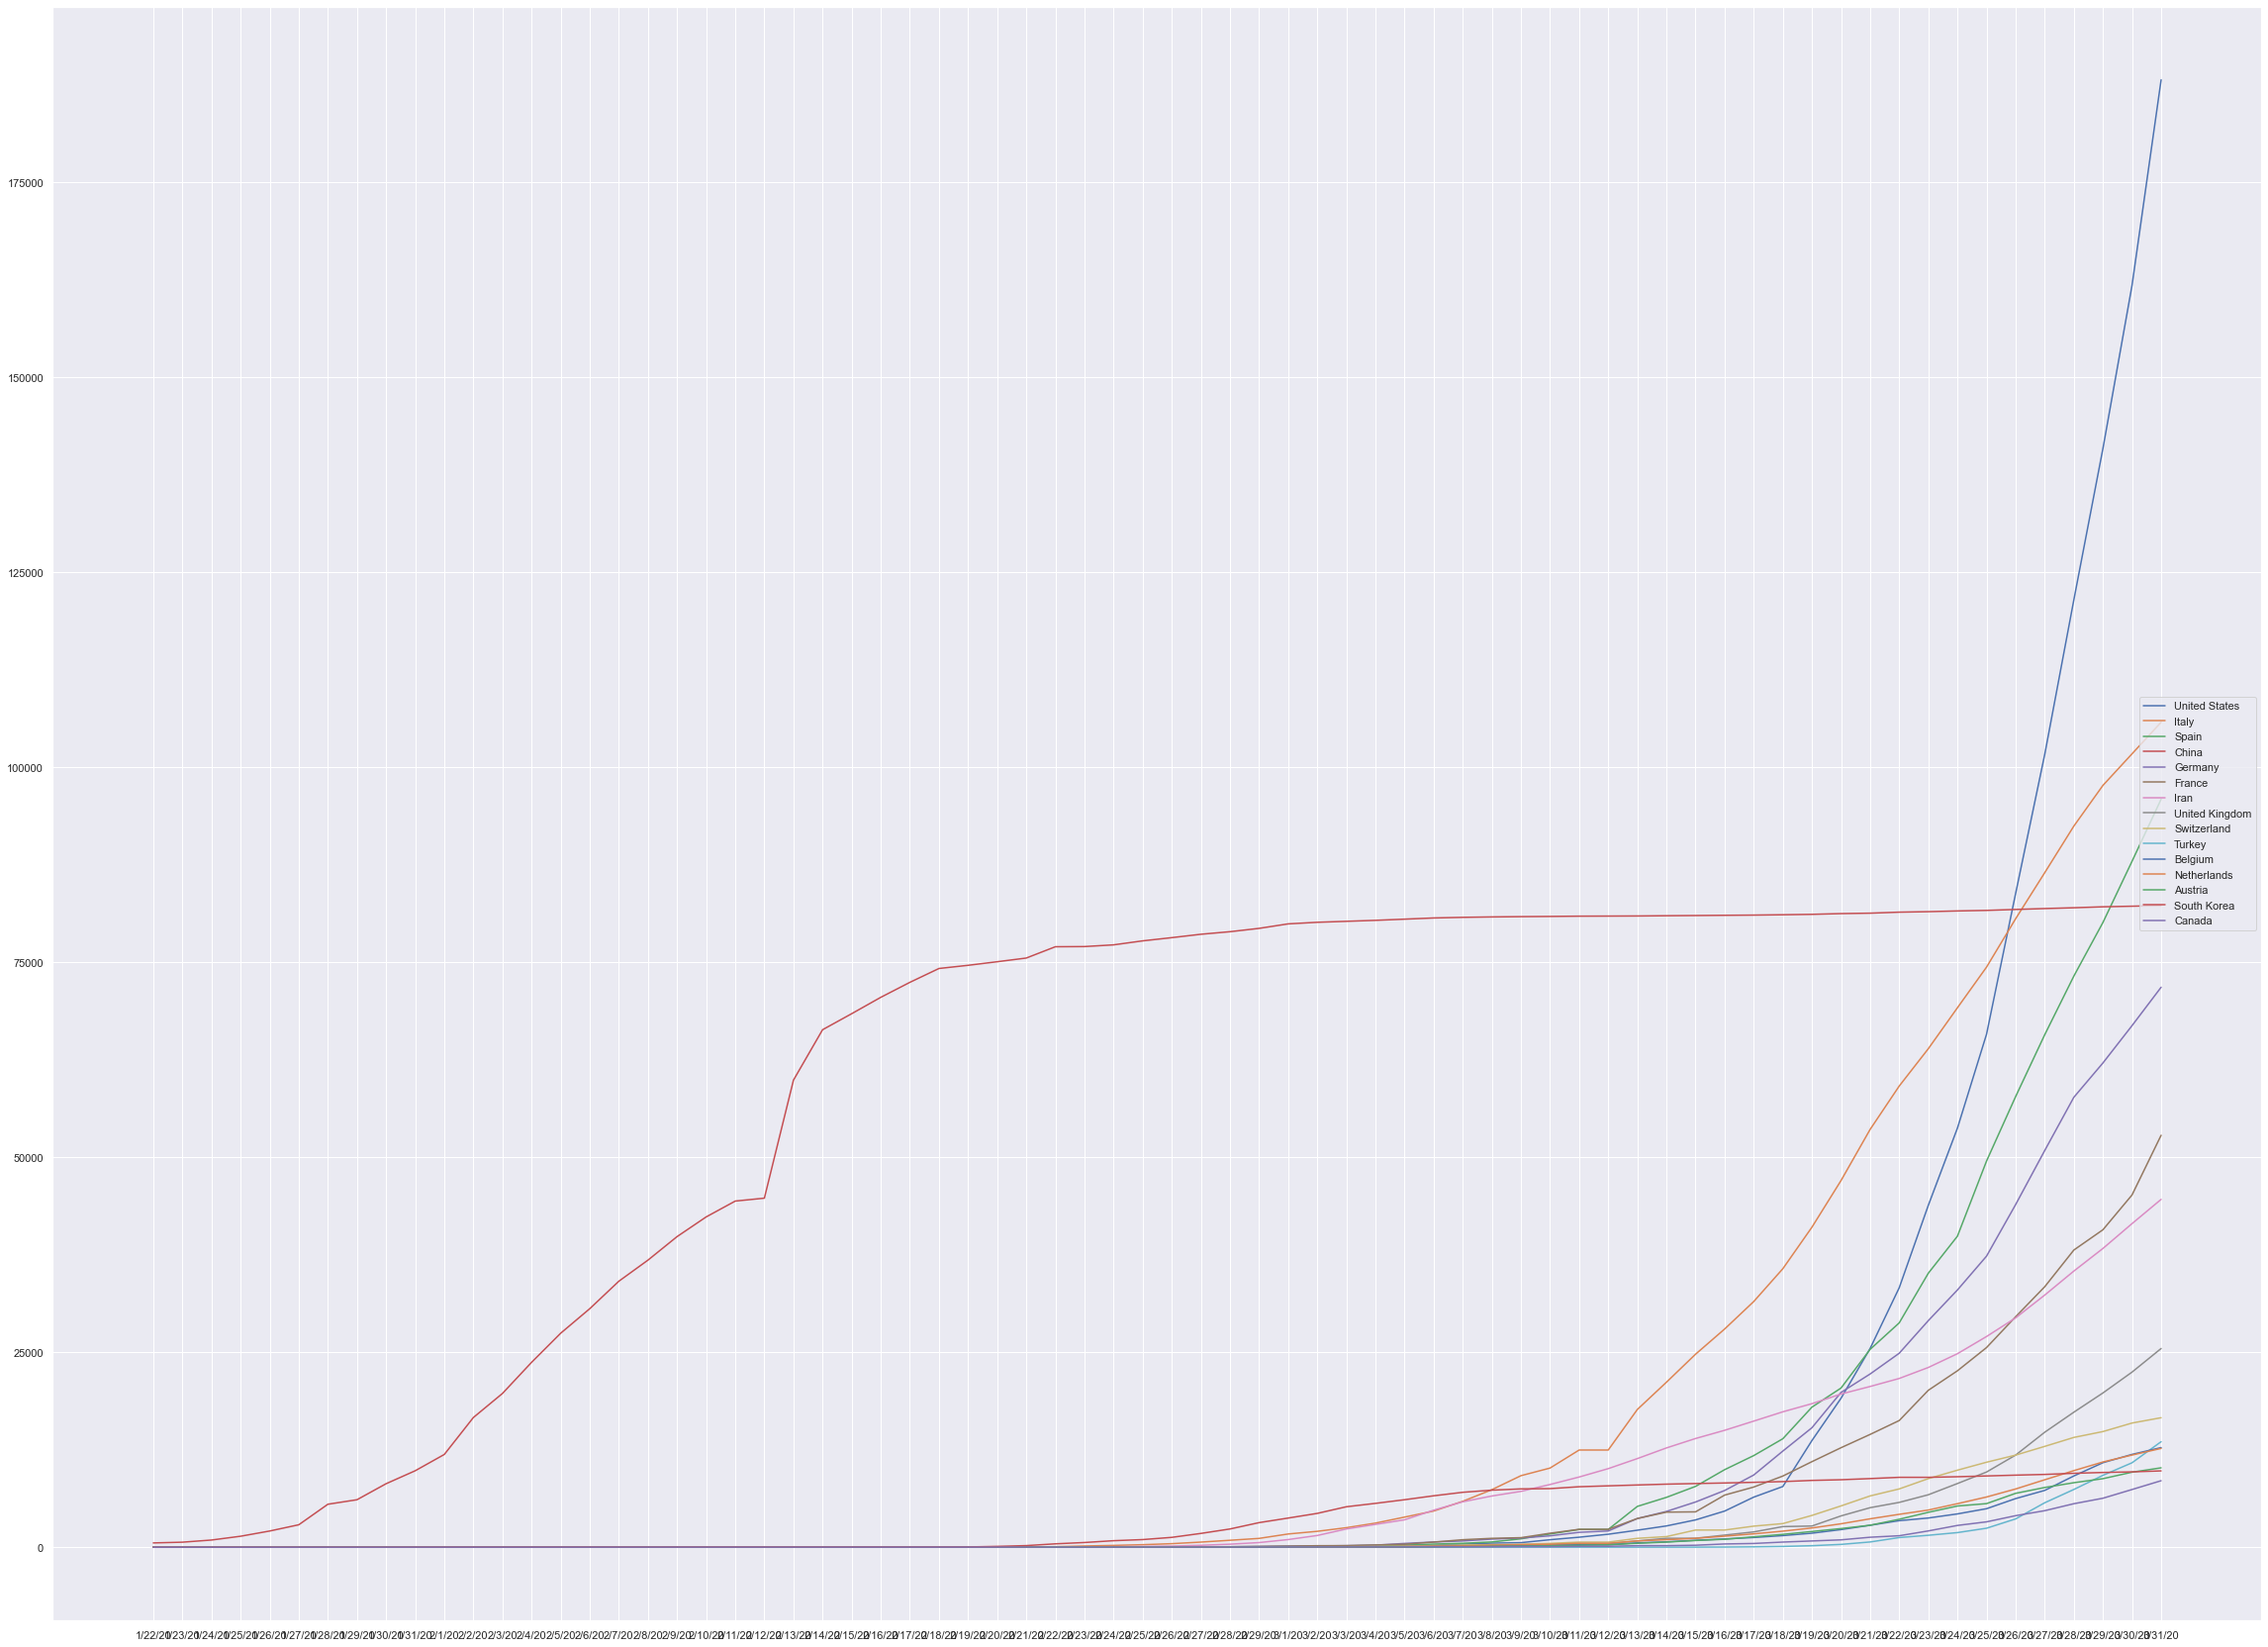

In [418]:
# Plot All countries 

# num_countries = 100
# cases_gt_100_cols = np.random.choice(cases_gt_100_T.columns.values, num_countries, replace=False)

cases_gt_100_T_index = cases_gt_100_T.index.values
plt.plot(cases_gt_100_T[cases_top_n])
plt.legend(cases_top_n, loc='center right')

### China and South Korea (at current date: 4/1/2020) has tailed off and thus follows a logistic curve

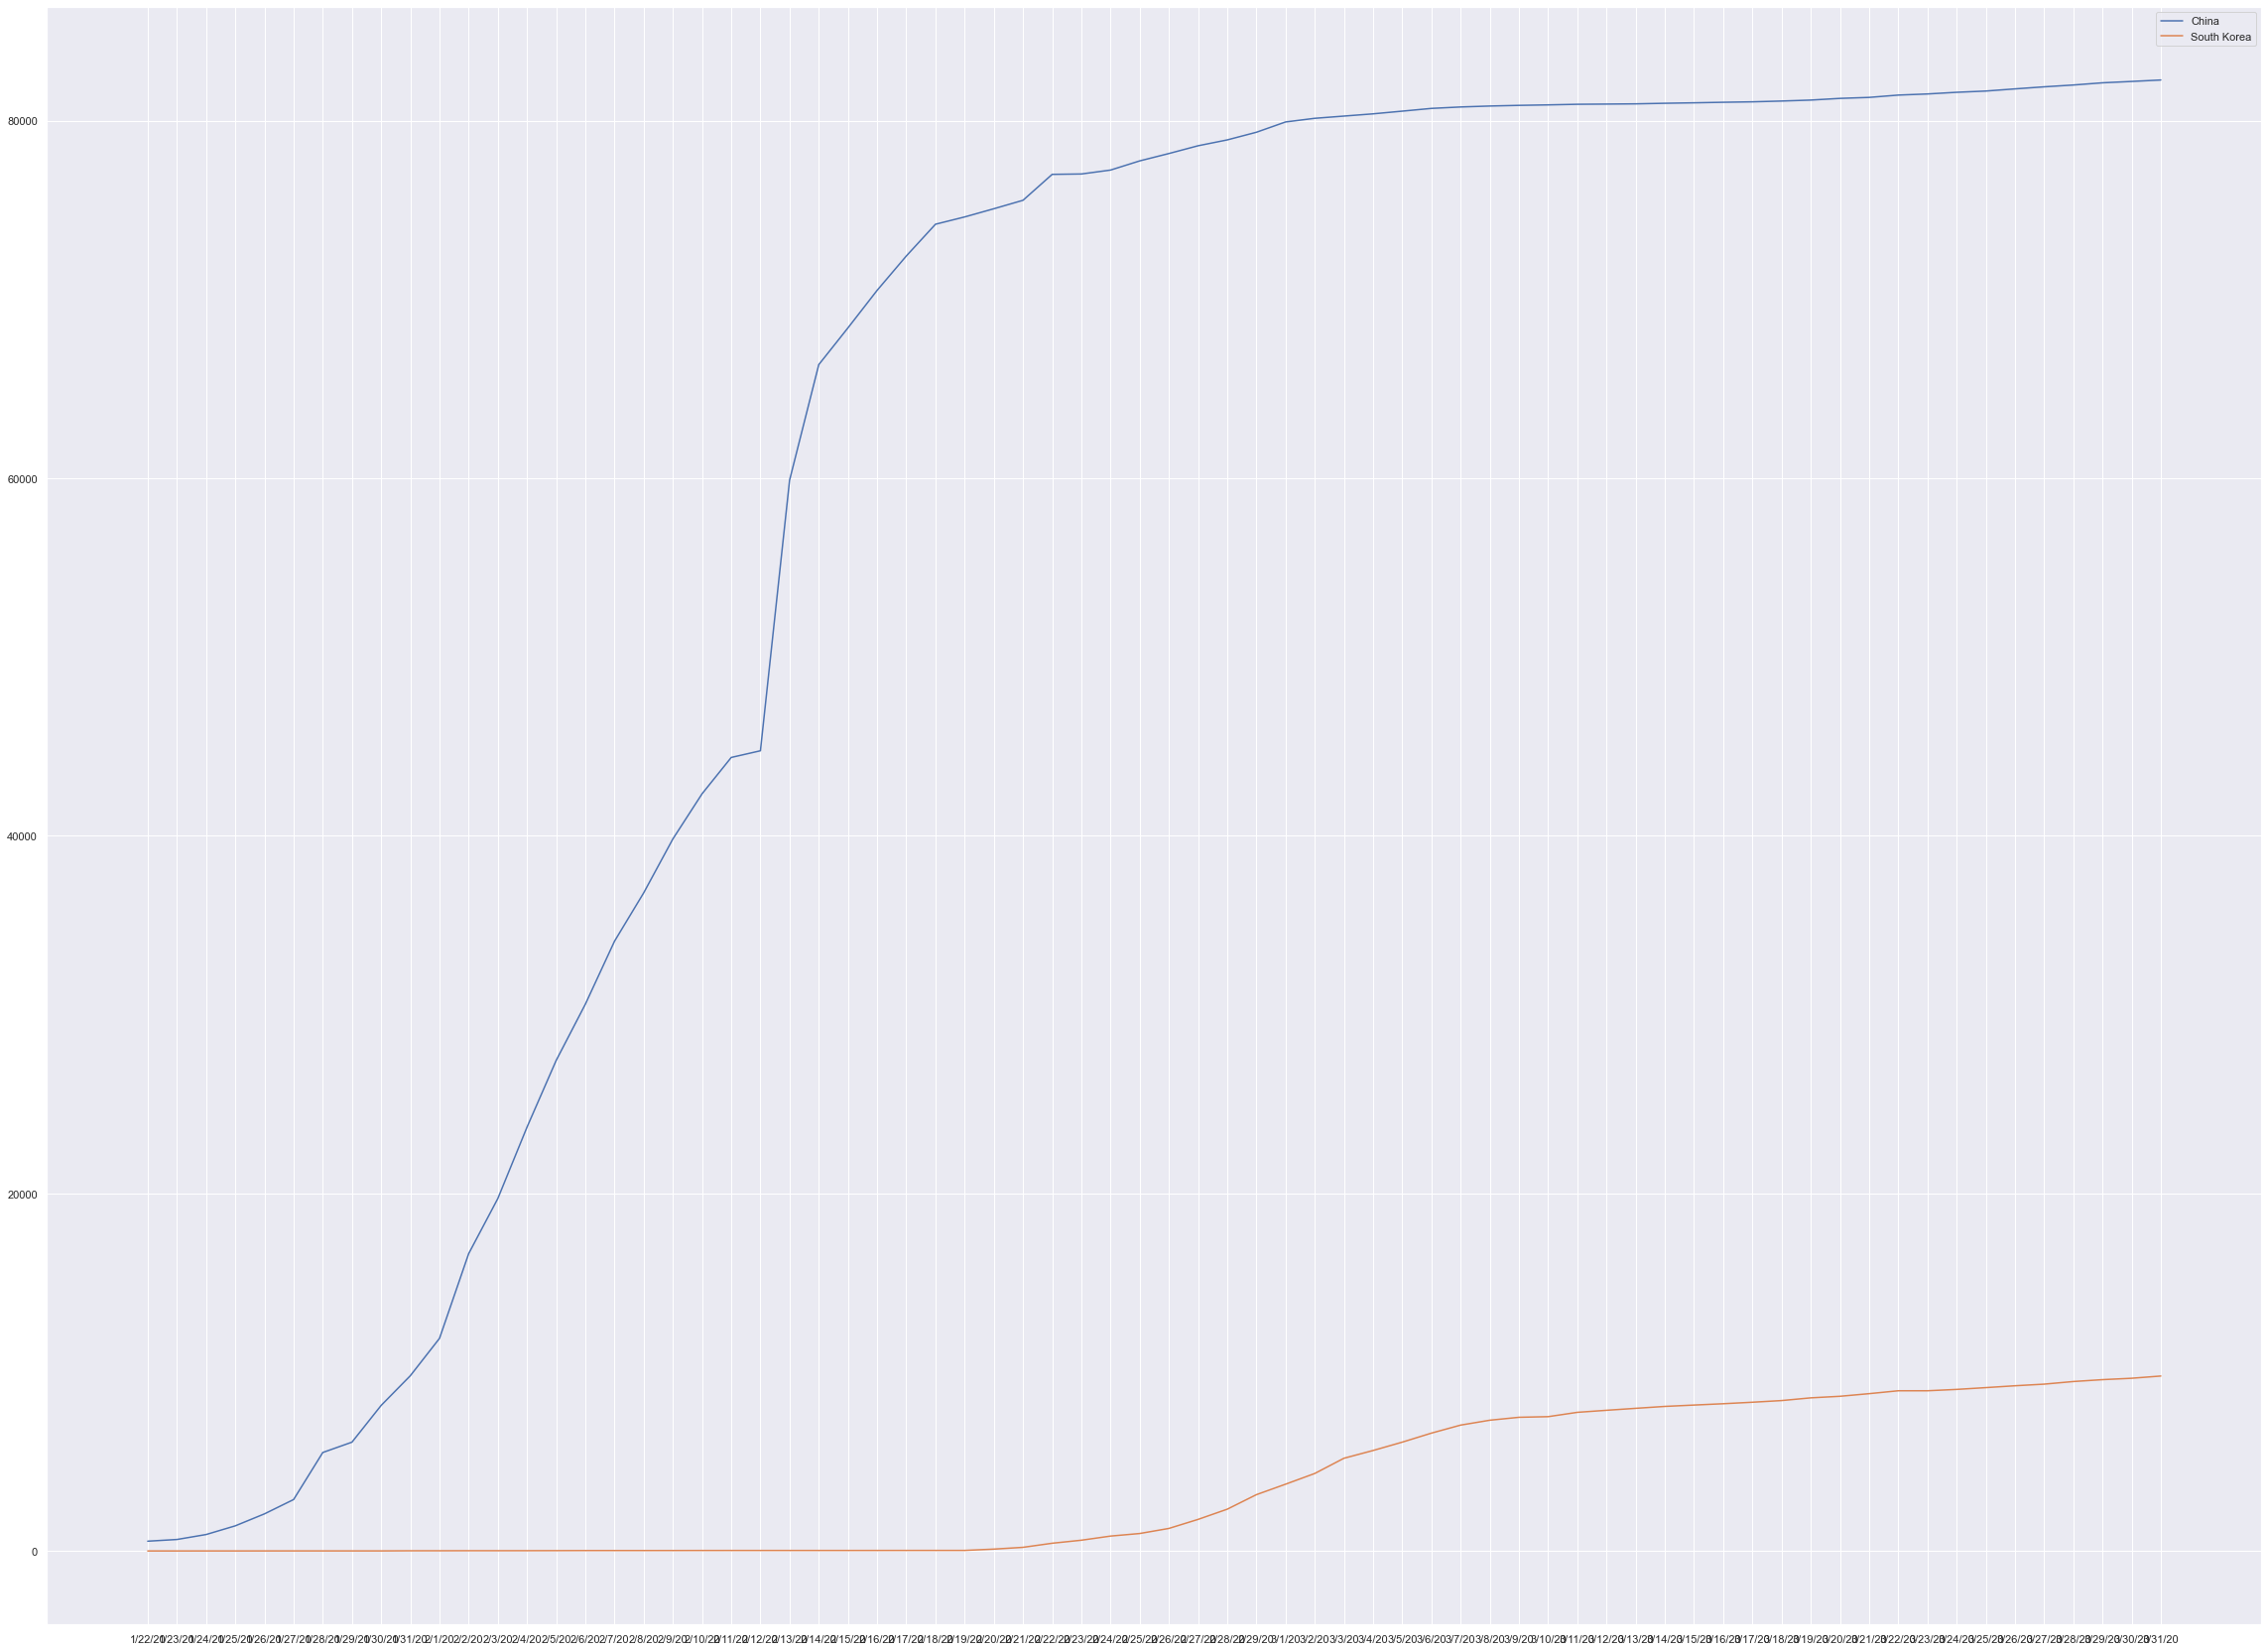

In [419]:
# Plot China and Korea
cases_gt_100_T_index = cases_gt_100_T.index.values
plt.plot(cases_gt_100_T[["China", "South Korea"]])
plt.legend(["China", "South Korea"], loc='best')

In [420]:
oxford_stringency.T[cases_top_n]

CountryName,United States,Italy,Spain,China,Germany,France,Iran,United Kingdom,Switzerland,Turkey,Belgium,Netherlands,Austria,South Korea,Canada
1/1/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/2/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/3/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/4/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/5/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/27/20,67.0,90.0,90.0,76.0,71.0,86.0,71.0,64.0,90.0,71.0,86.0,86.0,95.0,74.0,67.0
3/28/20,67.0,90.0,90.0,67.0,71.0,86.0,71.0,64.0,90.0,86.0,86.0,86.0,95.0,74.0,67.0
3/29/20,67.0,90.0,90.0,67.0,71.0,86.0,71.0,71.0,90.0,90.0,86.0,86.0,95.0,74.0,67.0
3/30/20,67.0,90.0,90.0,67.0,71.0,86.0,71.0,71.0,90.0,90.0,86.0,86.0,95.0,74.0,67.0


In [421]:
cases_top_n

array(['United States', 'Italy', 'Spain', 'China', 'Germany', 'France',
       'Iran', 'United Kingdom', 'Switzerland', 'Turkey', 'Belgium',
       'Netherlands', 'Austria', 'South Korea', 'Canada'], dtype=object)

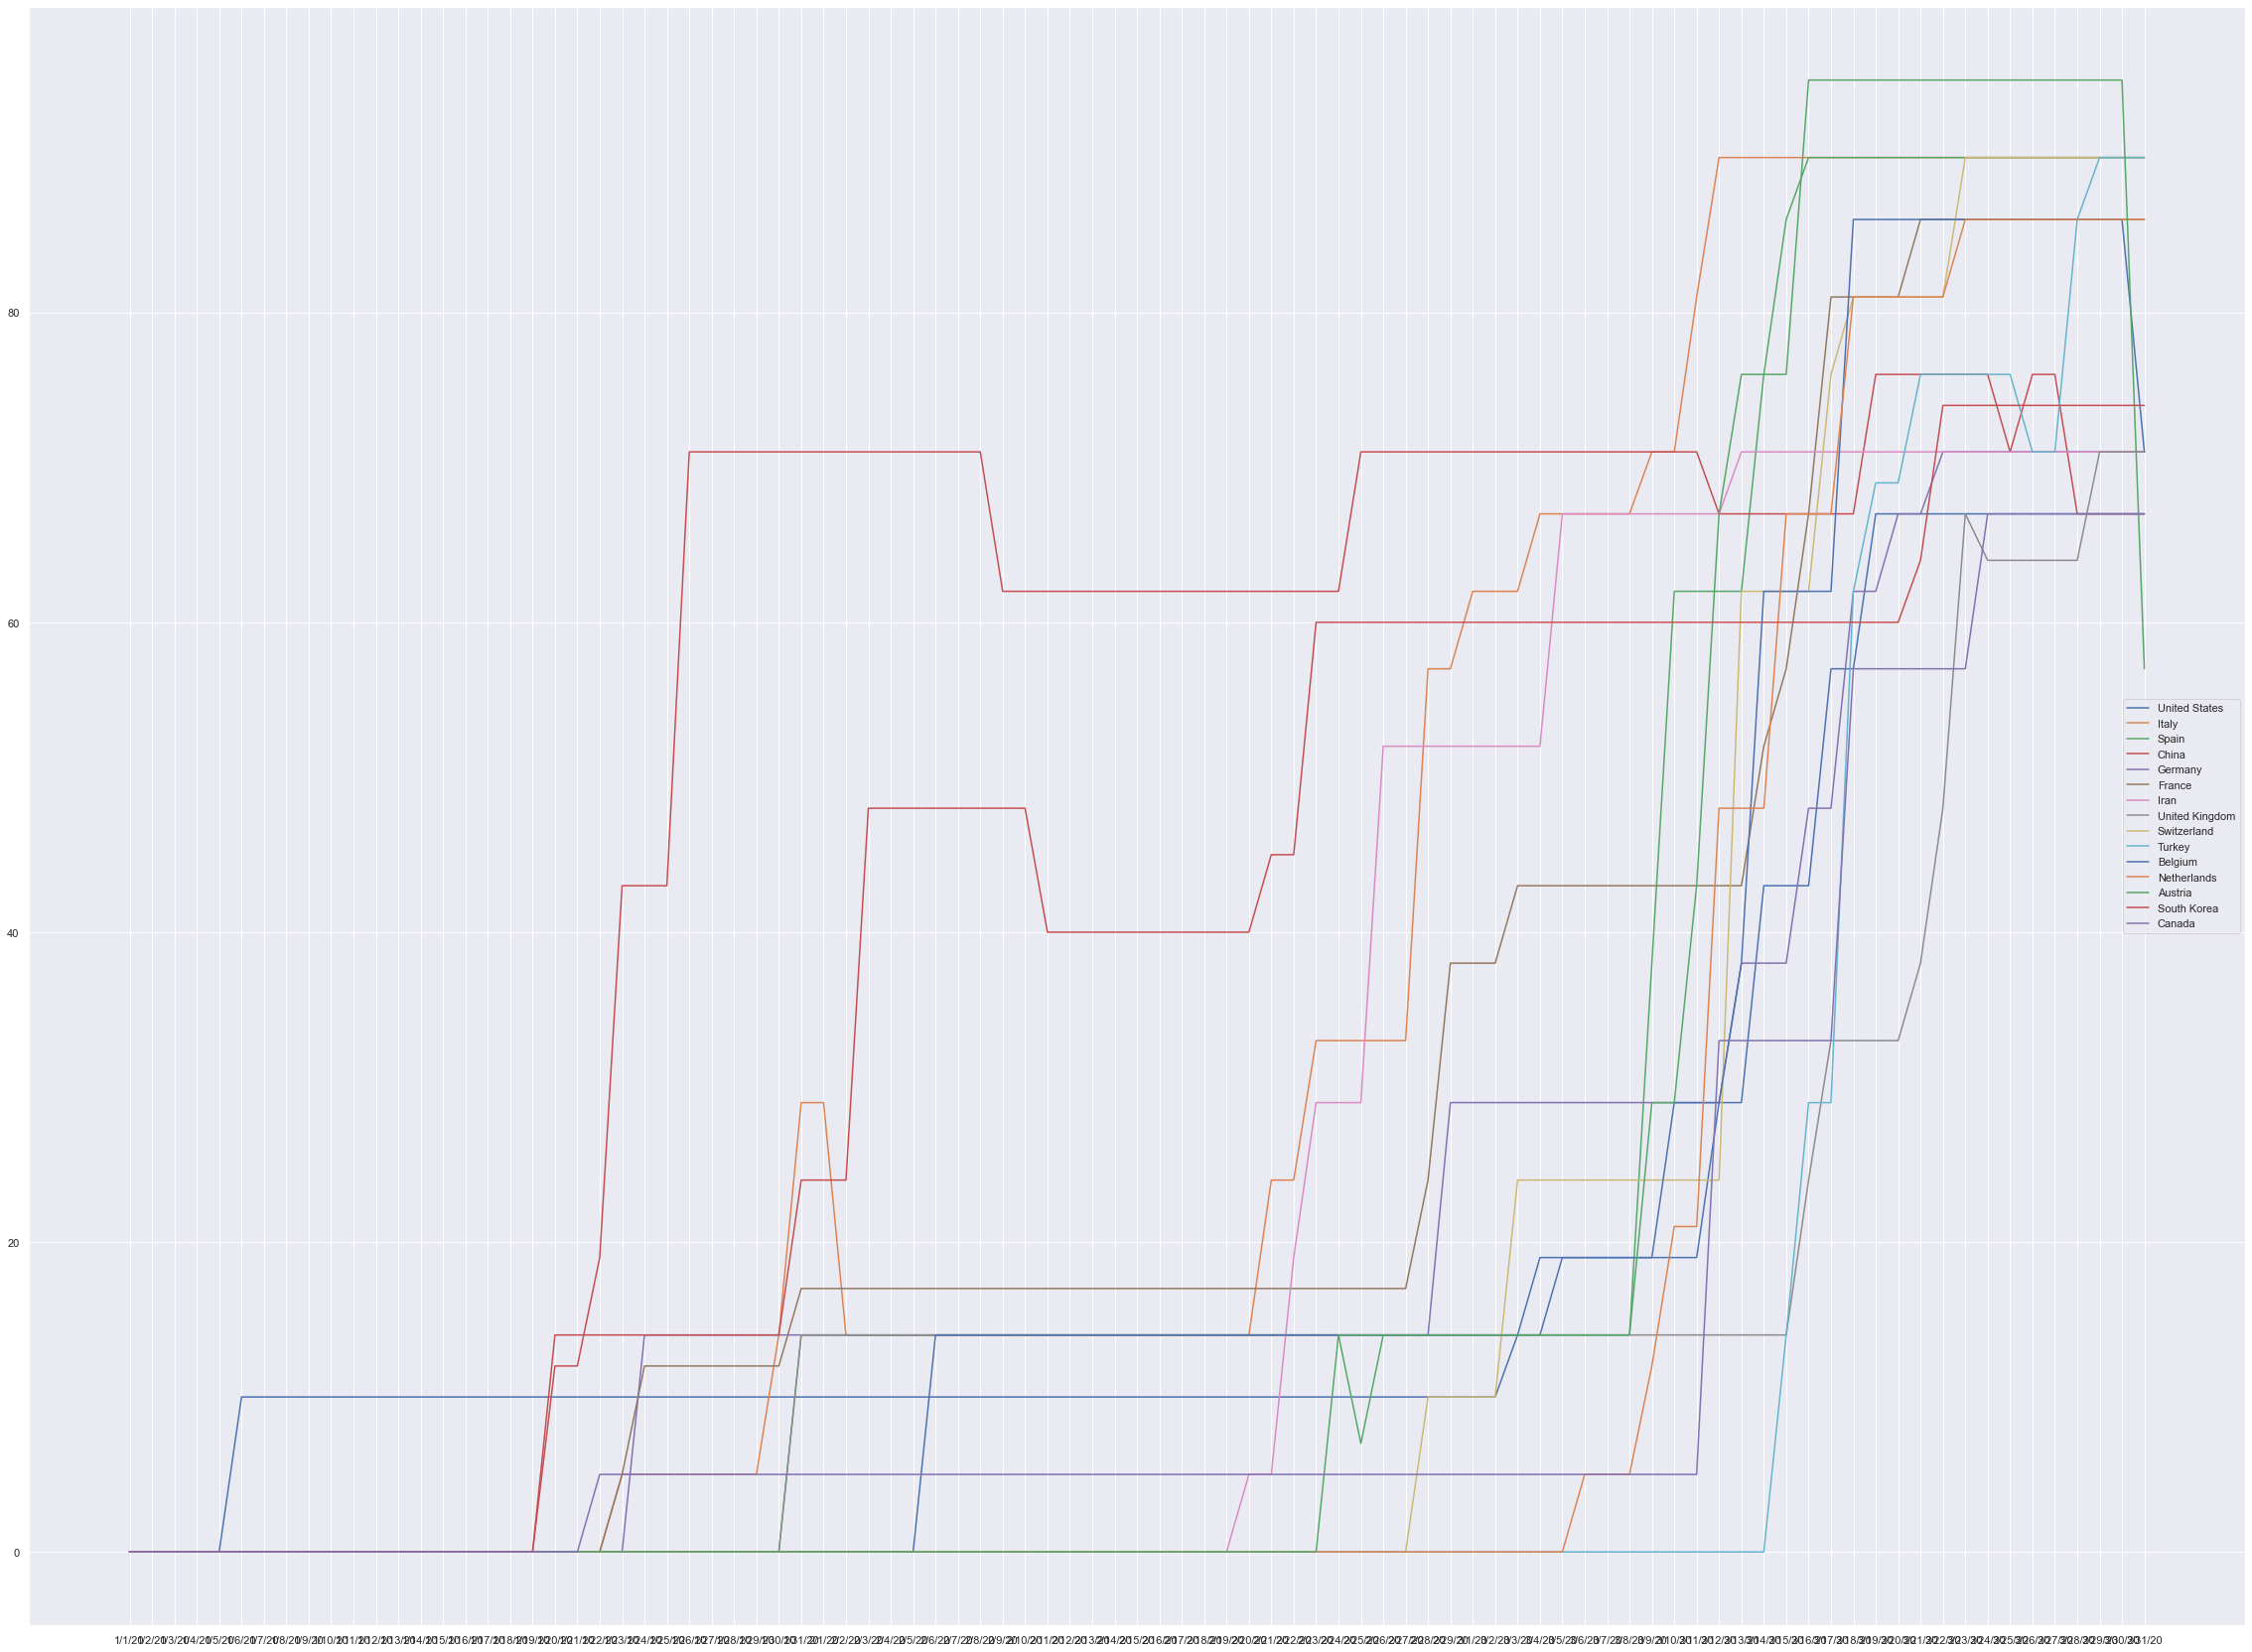

In [422]:

plt.plot(oxford_stringency.T[cases_top_n])
plt.legend(cases_top_n, loc='center right')

In [423]:
oxford_stringency.T

CountryName,Afghanistan,Algeria,Angola,Argentina,Aruba,Australia,Austria,Barbados,Belgium,Belize,...,Tanzania,Thailand,Turkey,Uganda,Ukraine,United Kingdom,United States,Venezuela,Vietnam,Zimbabwe
1/1/20,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/2/20,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/3/20,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/4/20,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/5/20,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/27/20,57.0,62.0,62.0,67.0,43.0,10.0,95.0,10.0,86.0,67.0,...,10.0,62.0,71.0,86.0,95.0,64.0,67.0,83.0,52.0,67.0
3/28/20,57.0,62.0,62.0,67.0,43.0,10.0,95.0,10.0,86.0,67.0,...,19.0,62.0,86.0,86.0,95.0,64.0,67.0,83.0,52.0,67.0
3/29/20,57.0,62.0,62.0,67.0,43.0,10.0,95.0,10.0,86.0,67.0,...,19.0,62.0,90.0,86.0,95.0,71.0,67.0,83.0,52.0,67.0
3/30/20,57.0,62.0,62.0,43.0,43.0,10.0,95.0,10.0,86.0,67.0,...,19.0,62.0,90.0,86.0,95.0,71.0,67.0,83.0,67.0,100.0


In [ ]:
# TODO: text onto the graph

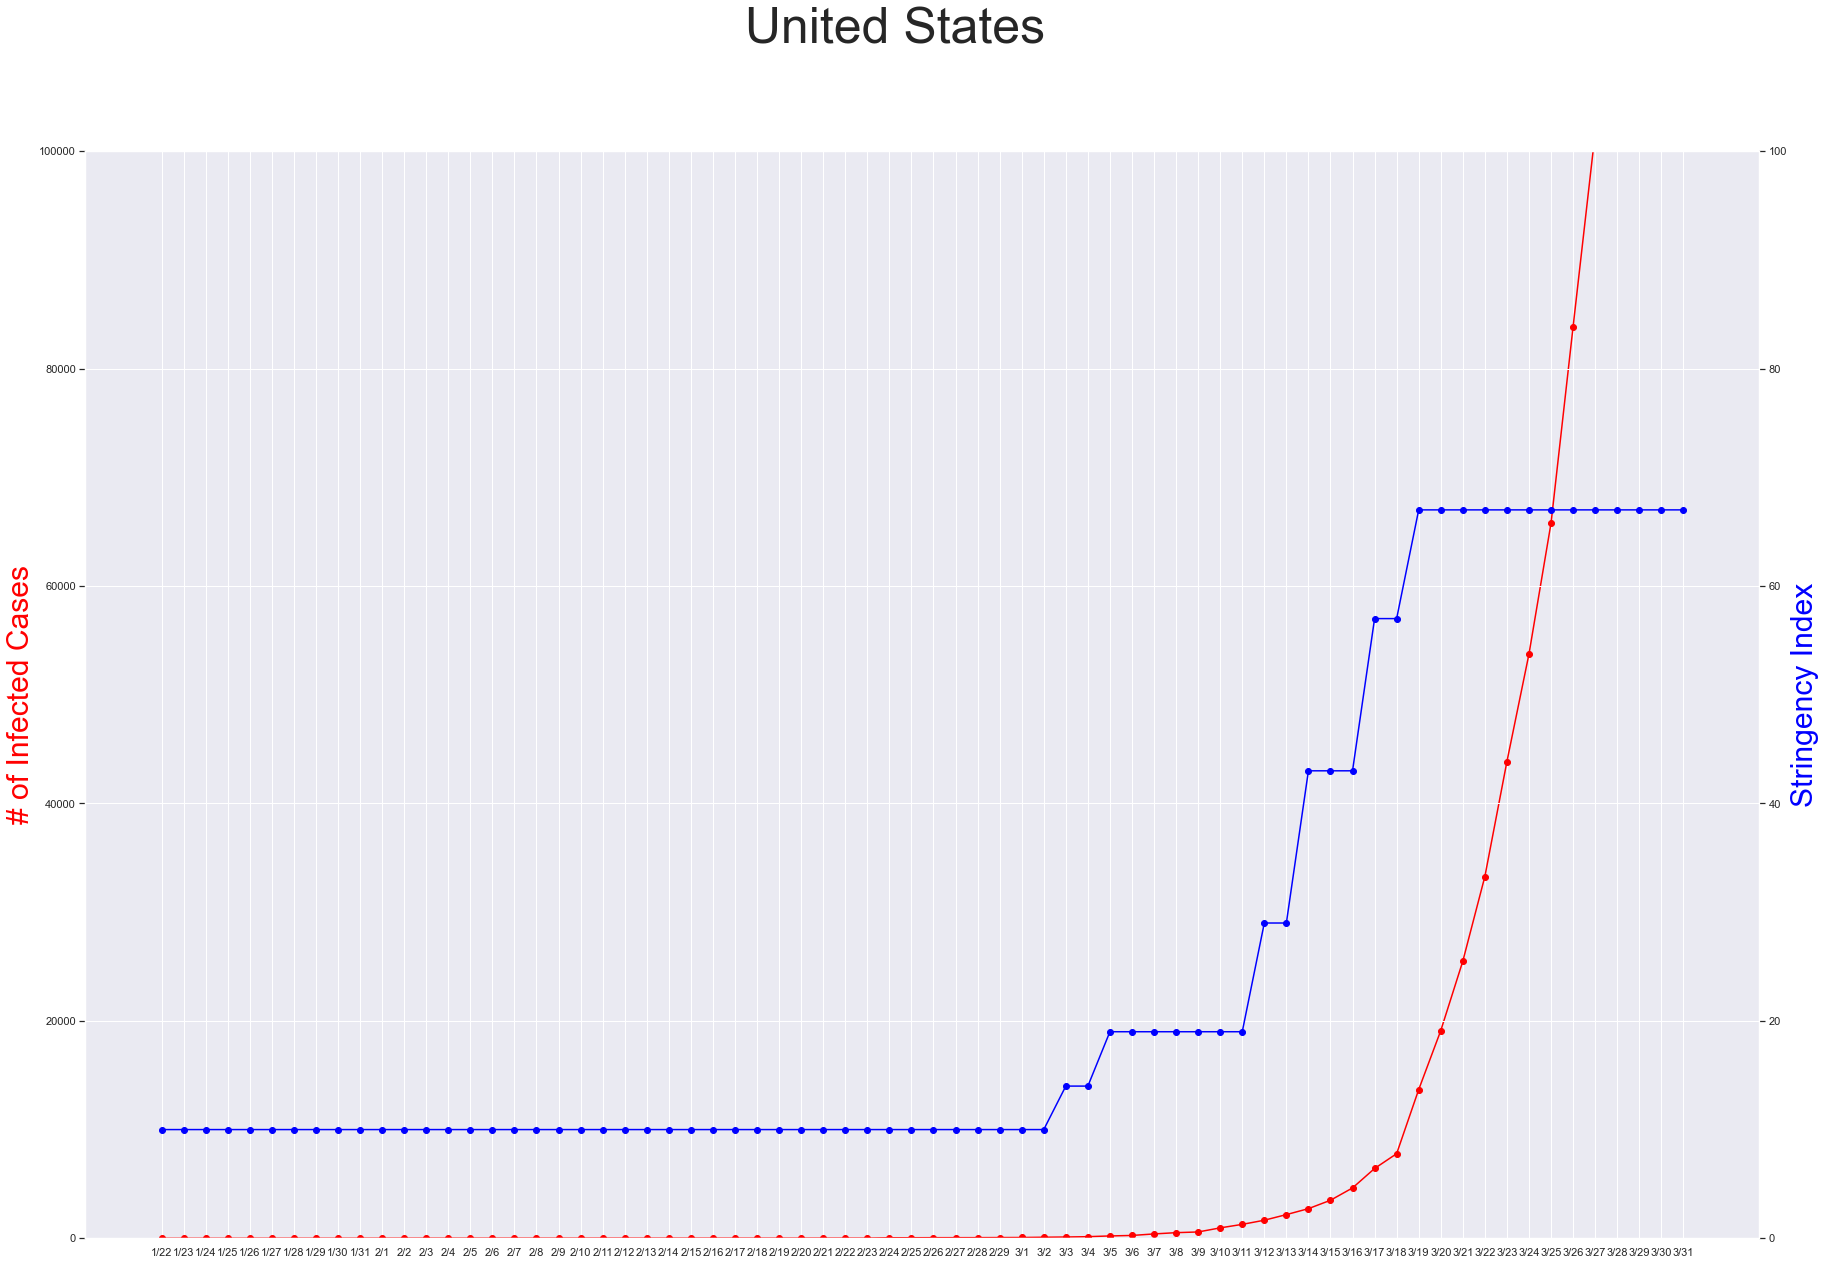

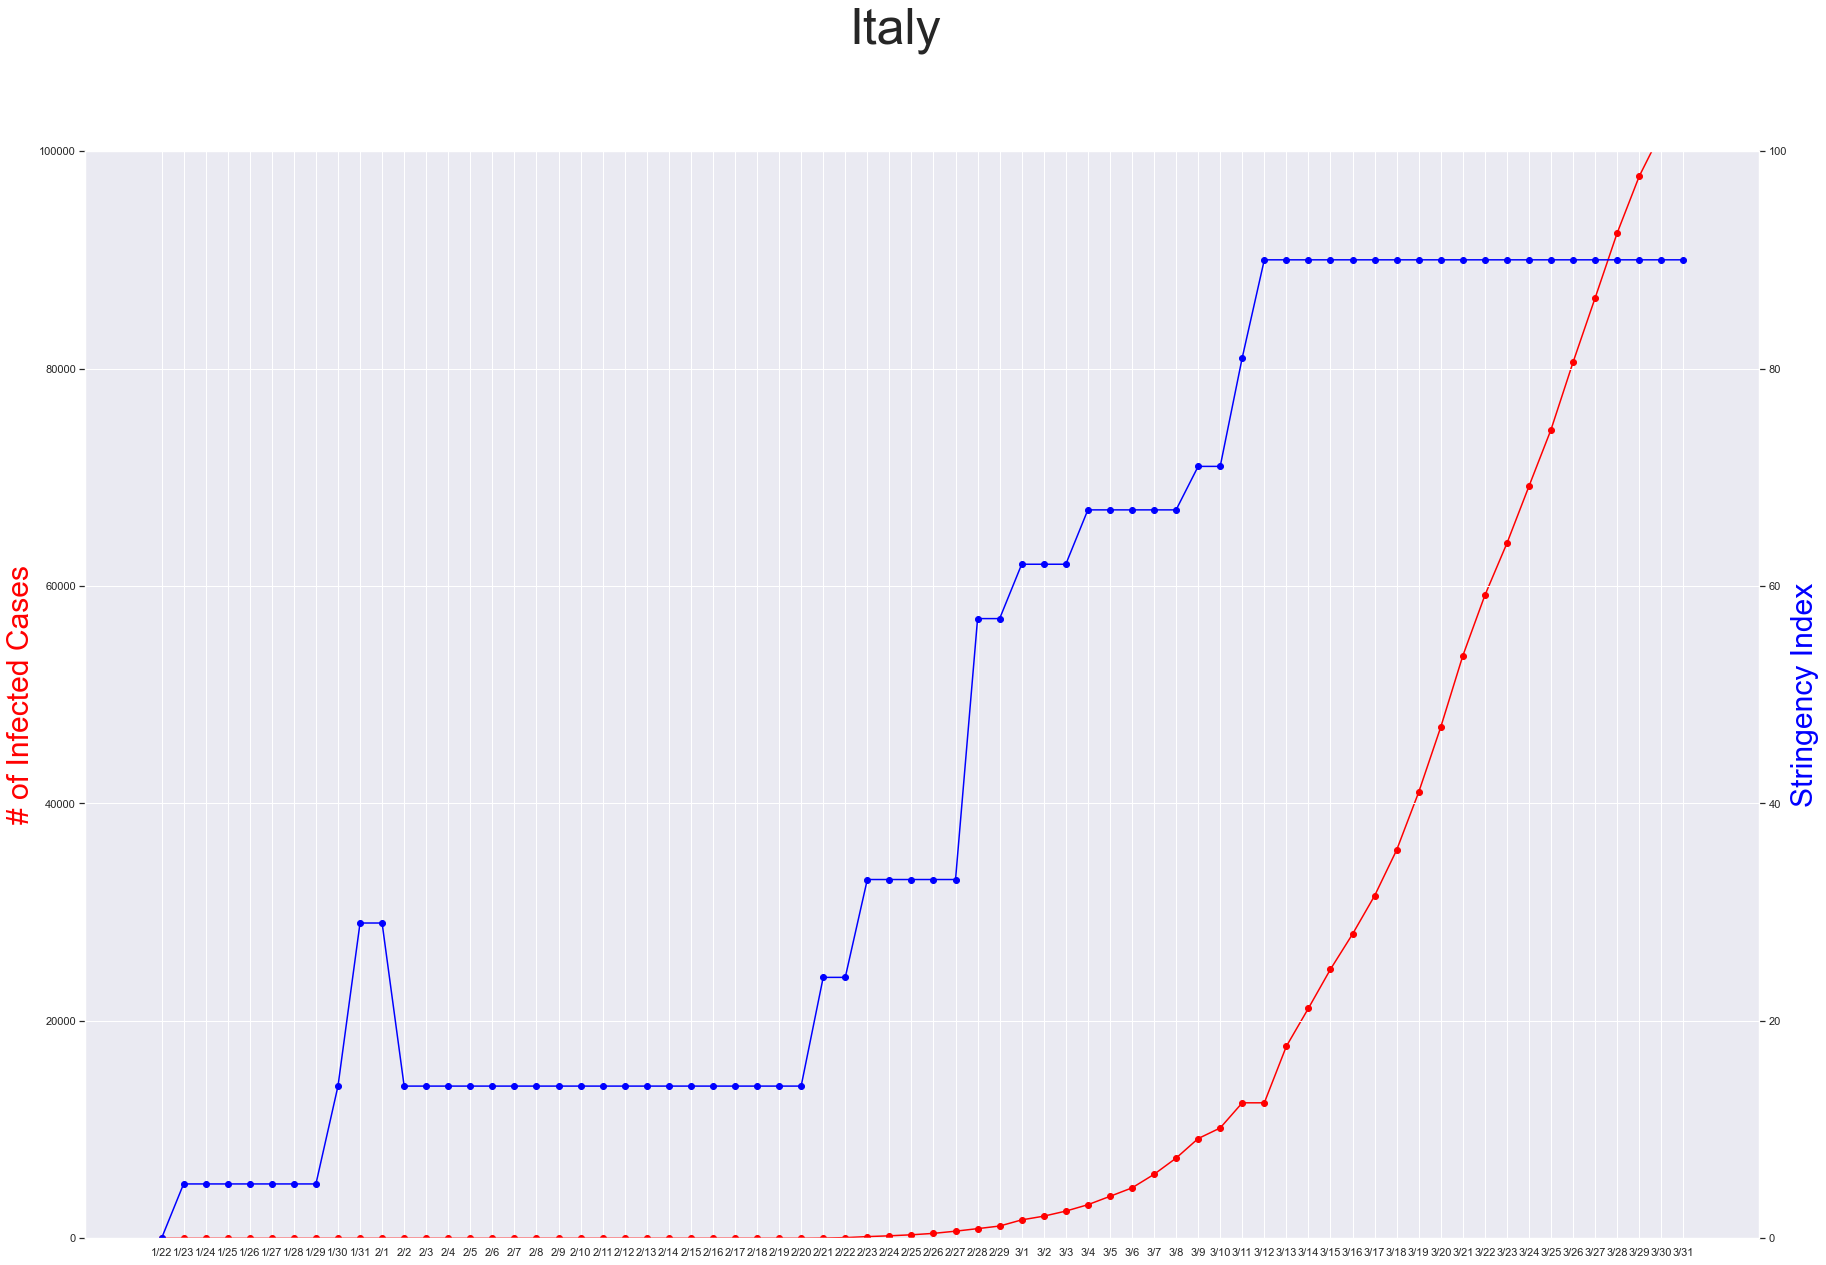

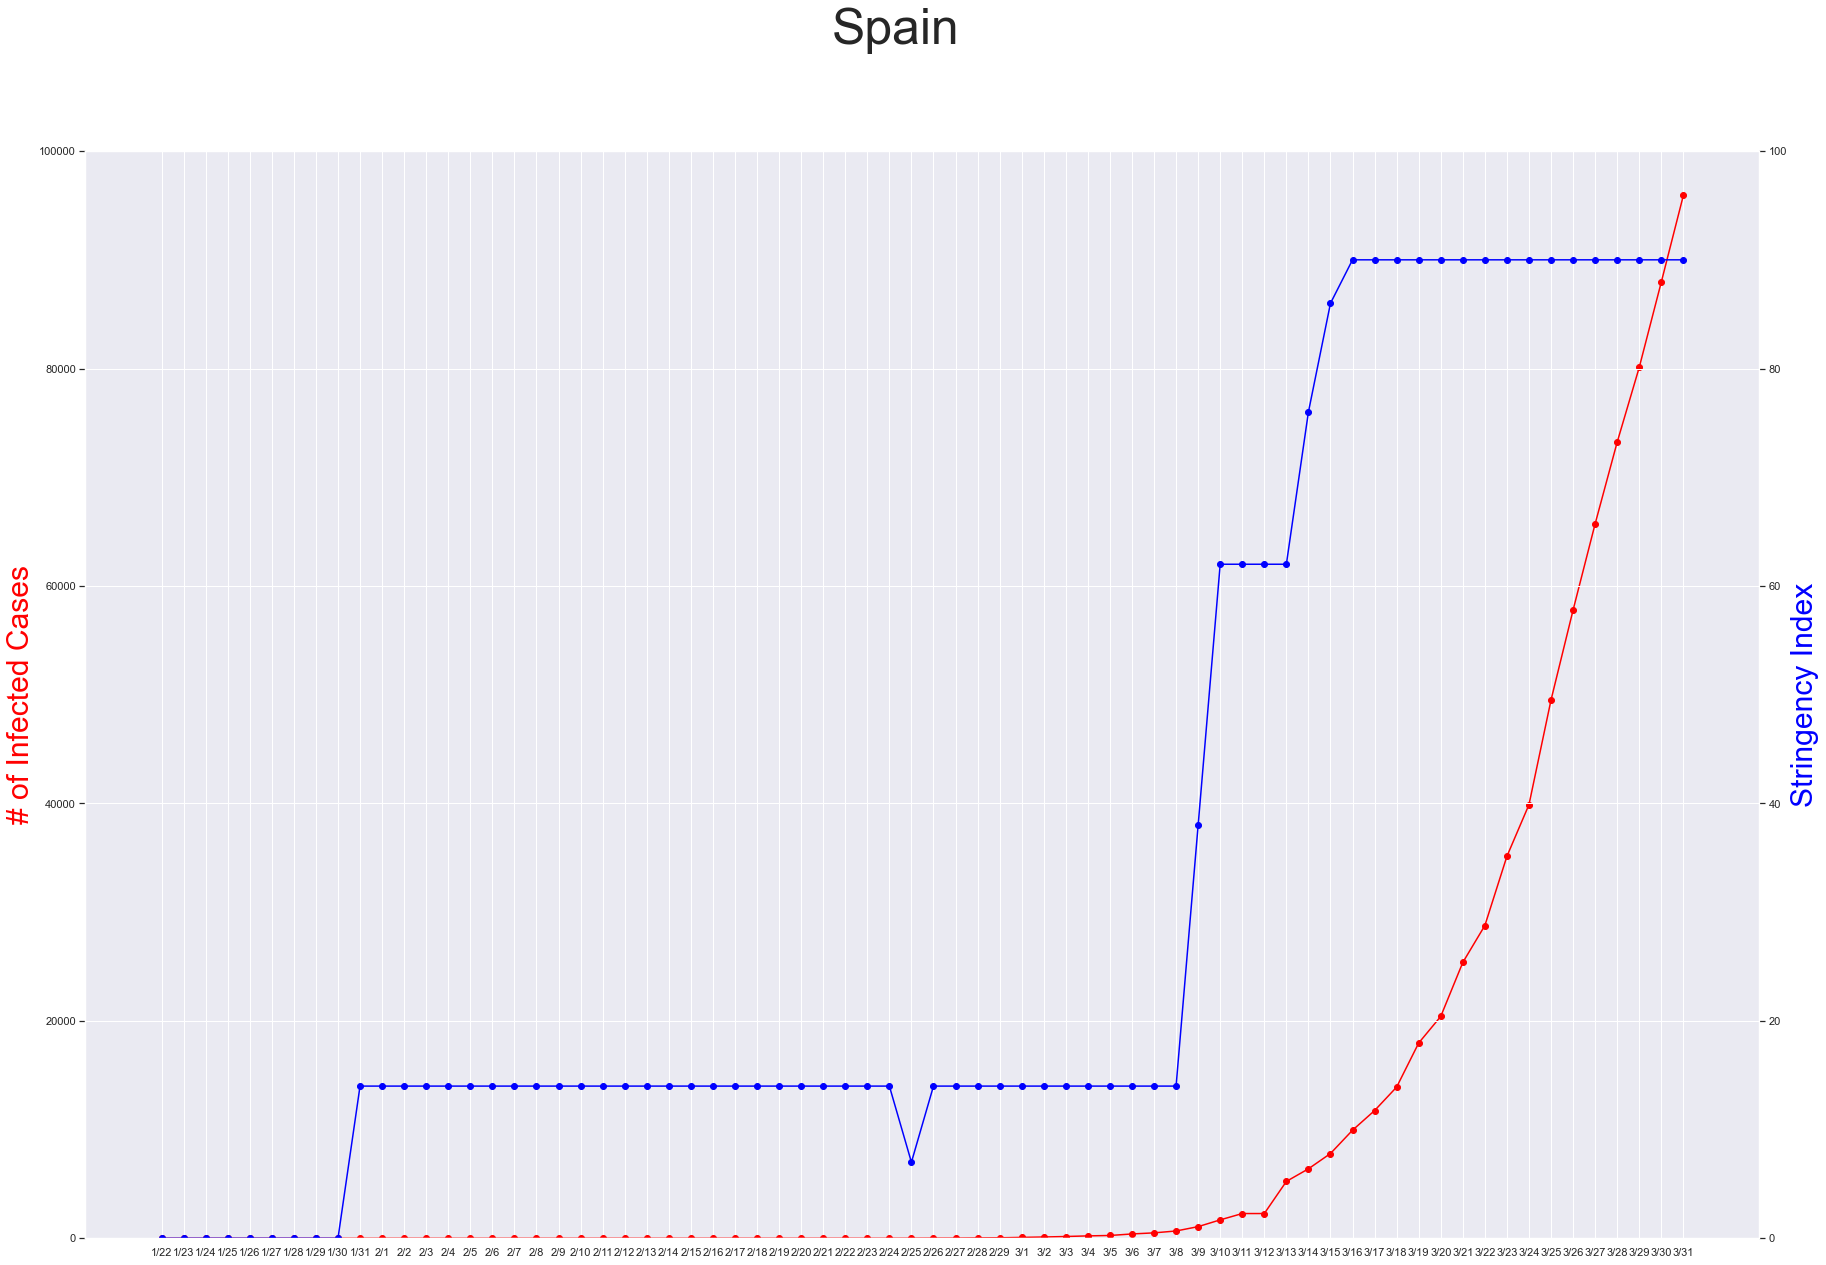

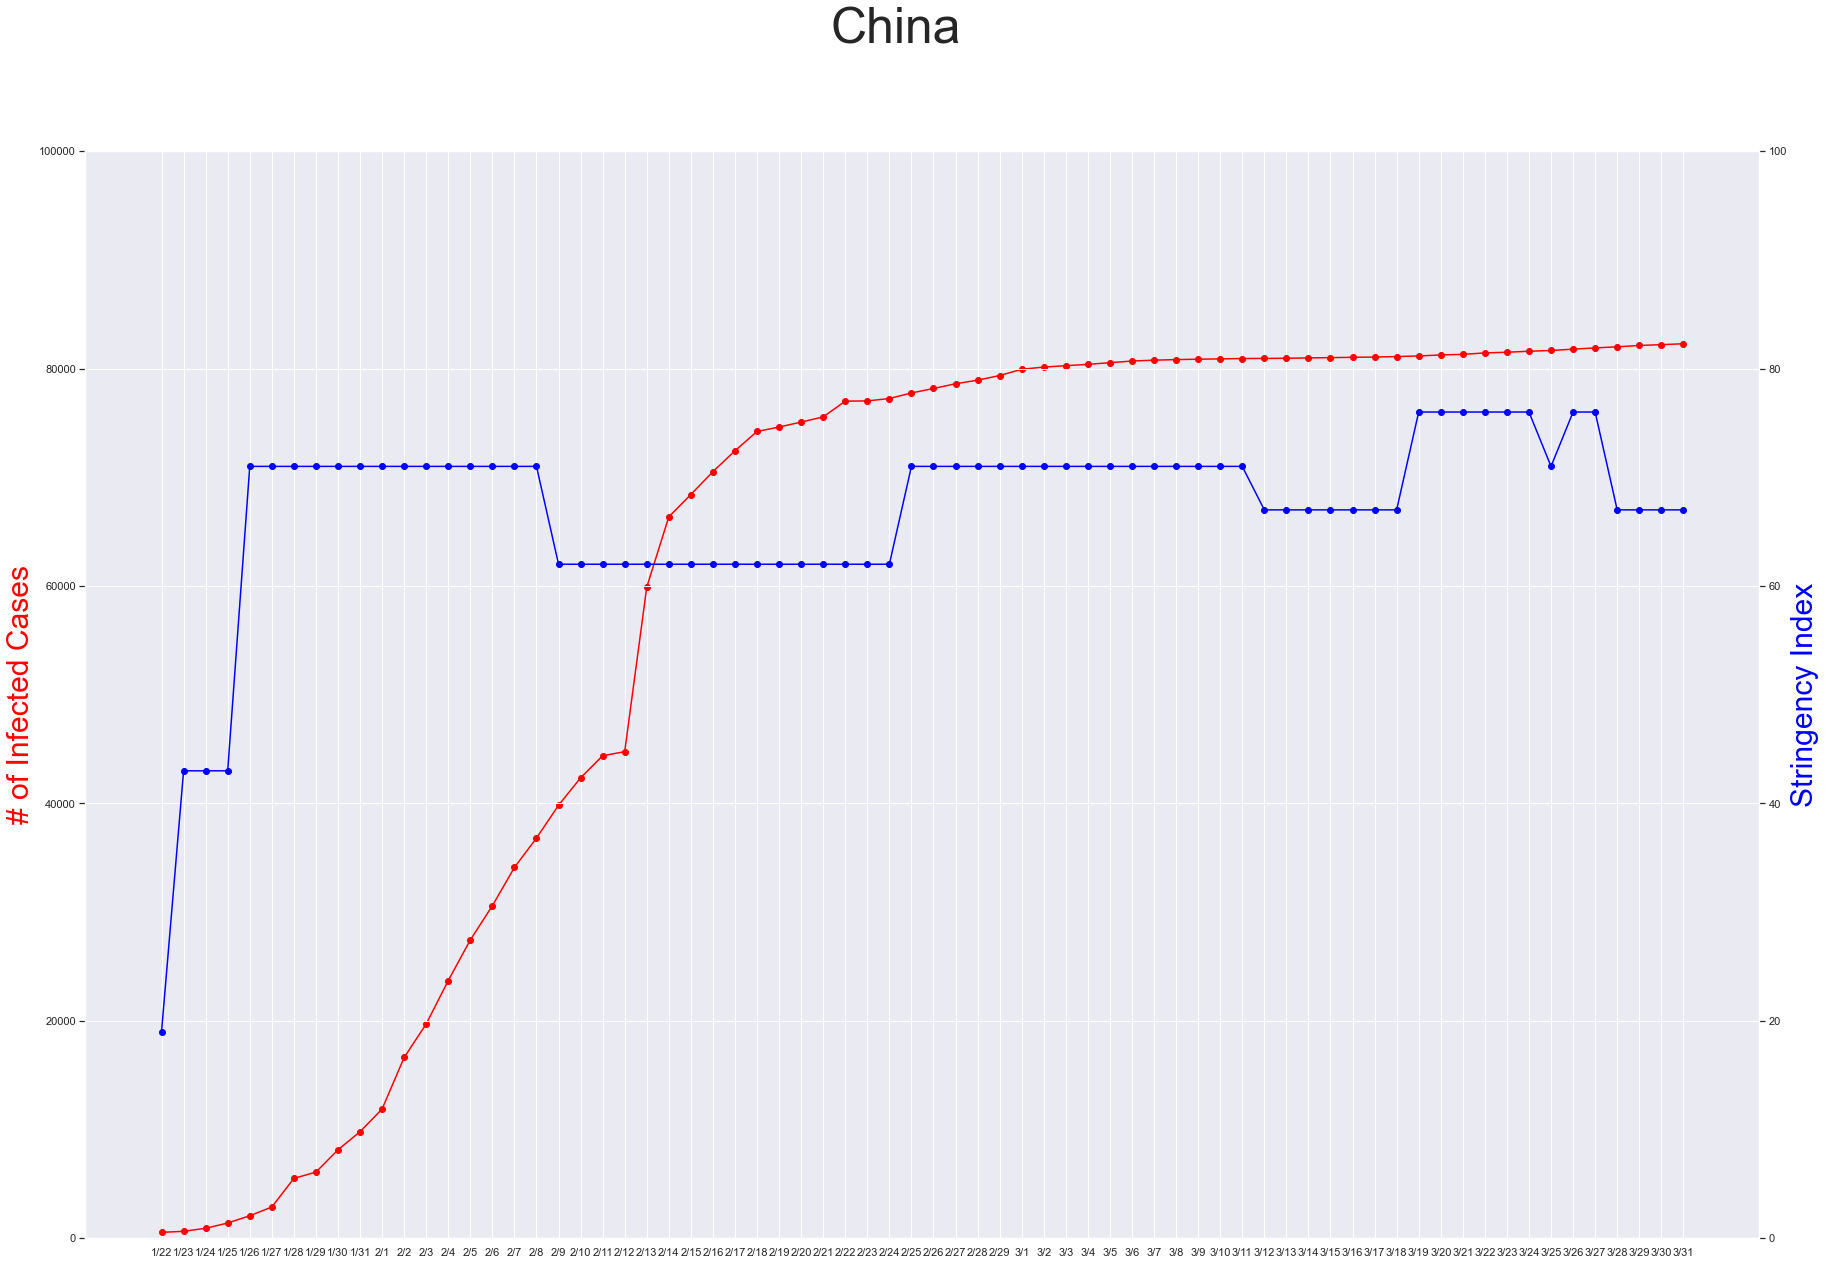

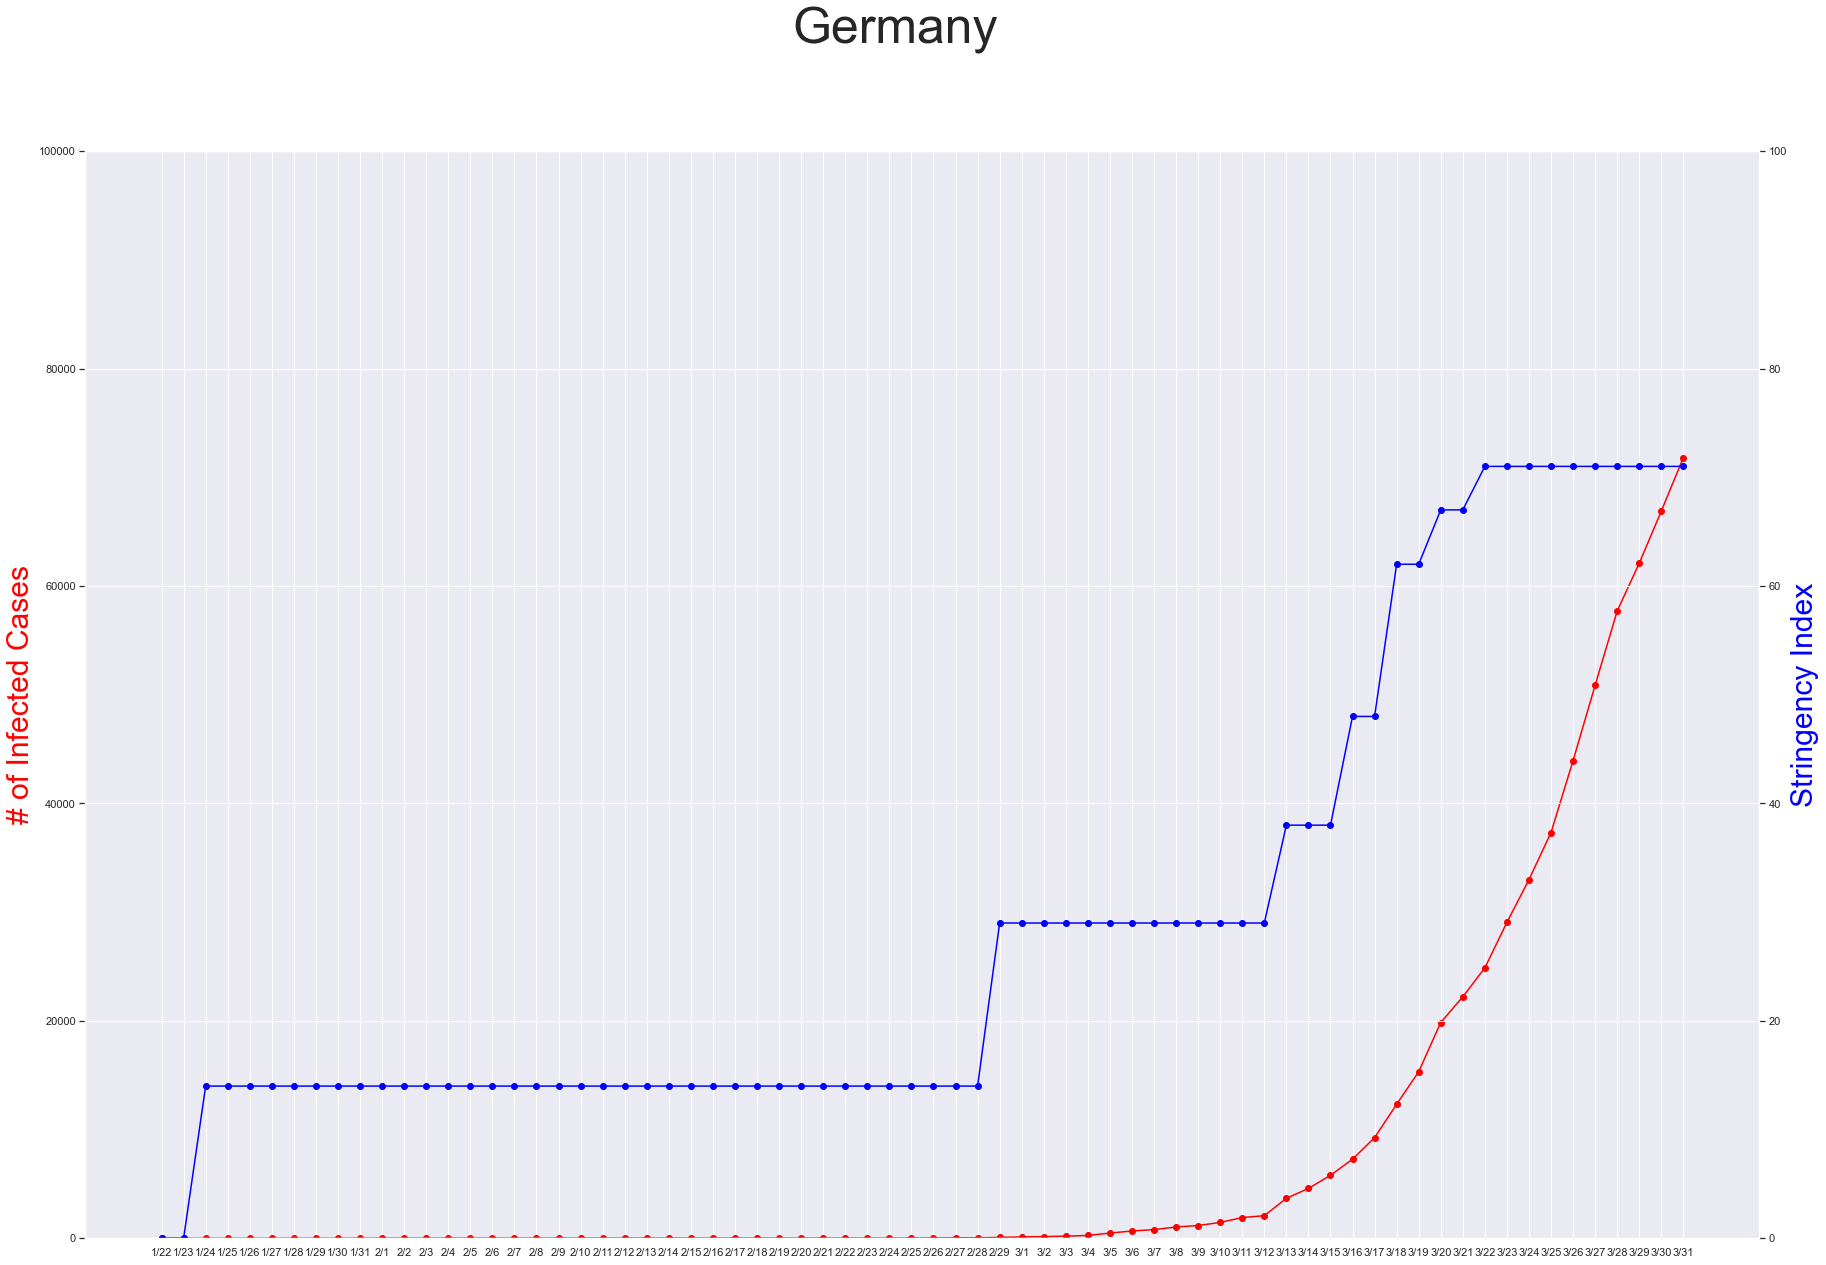

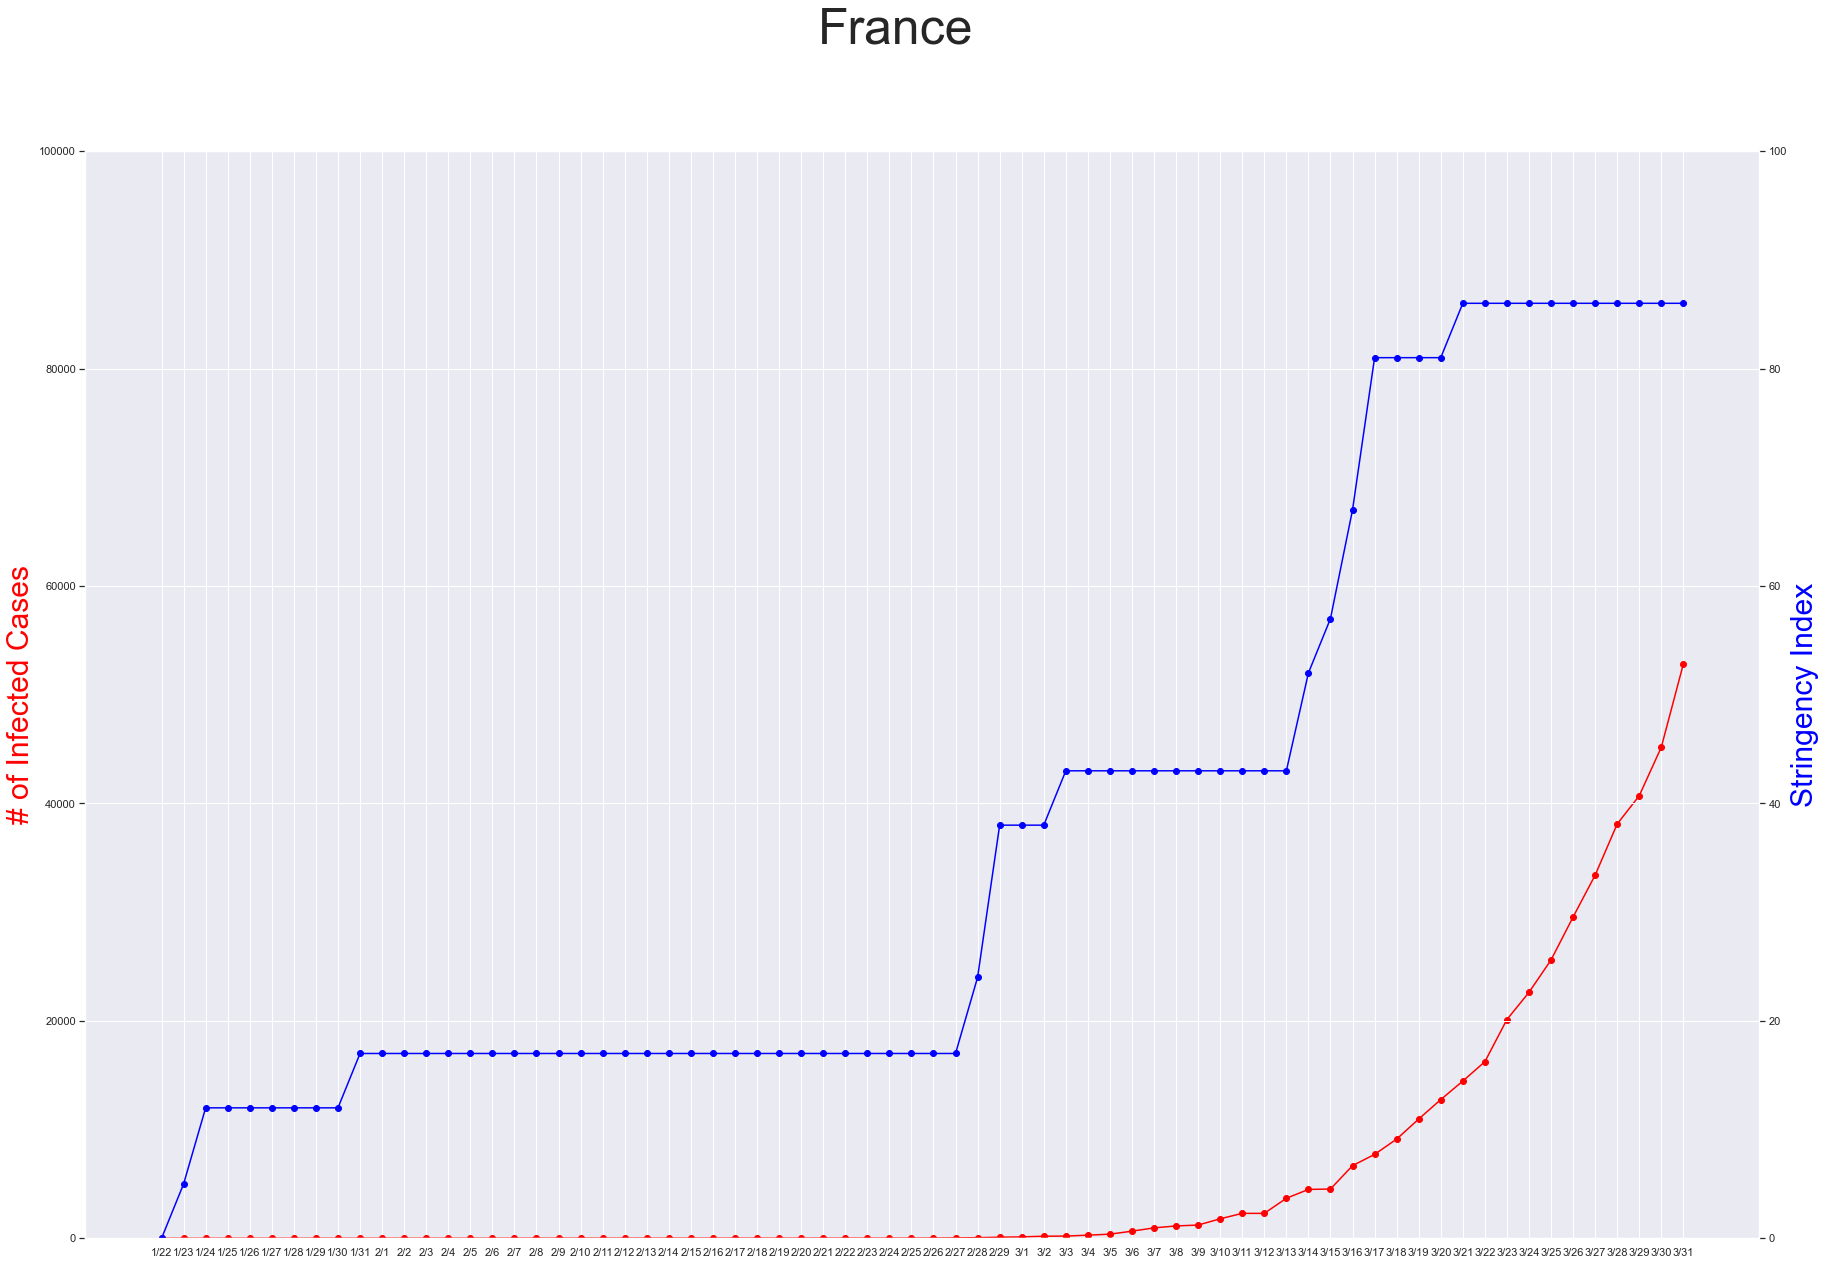

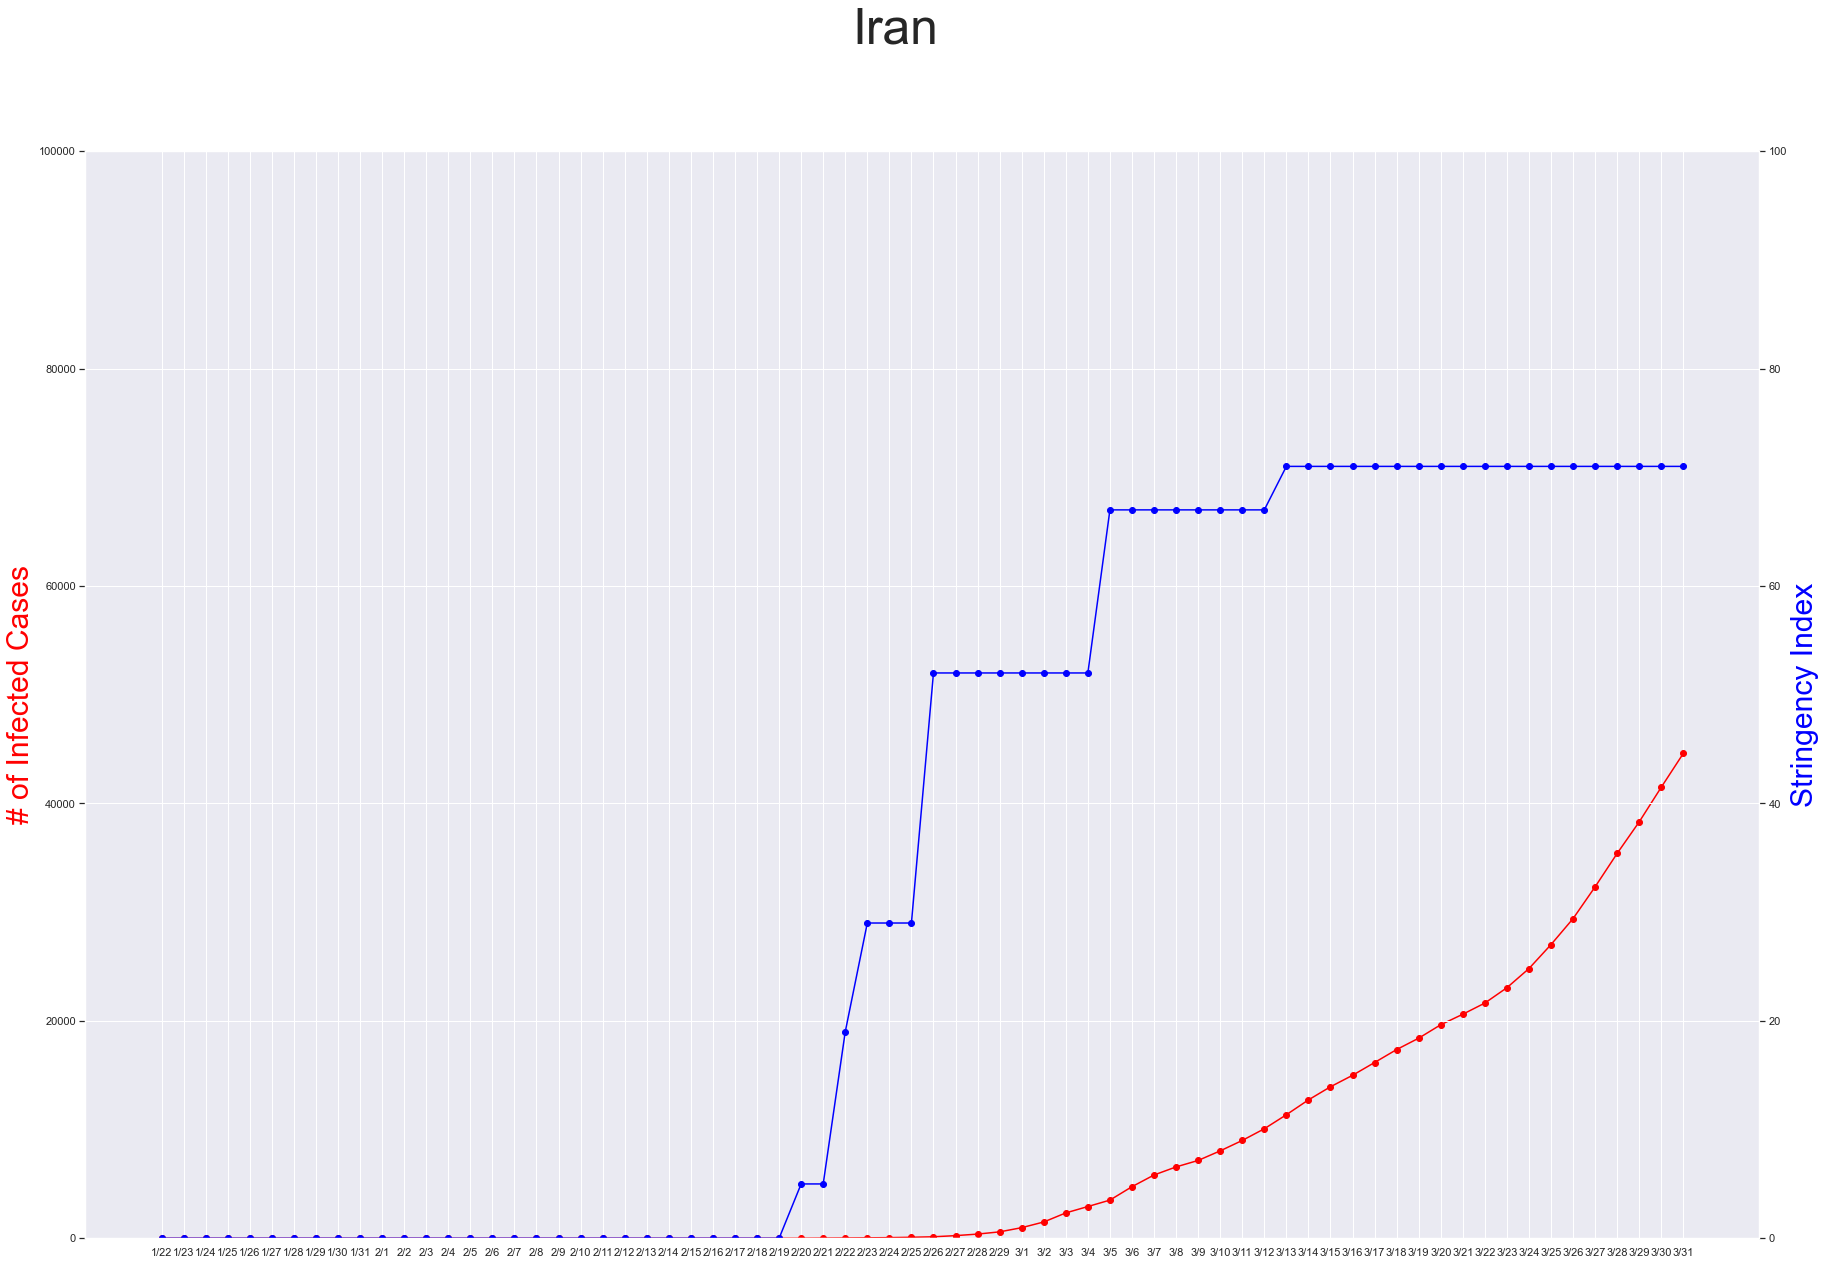

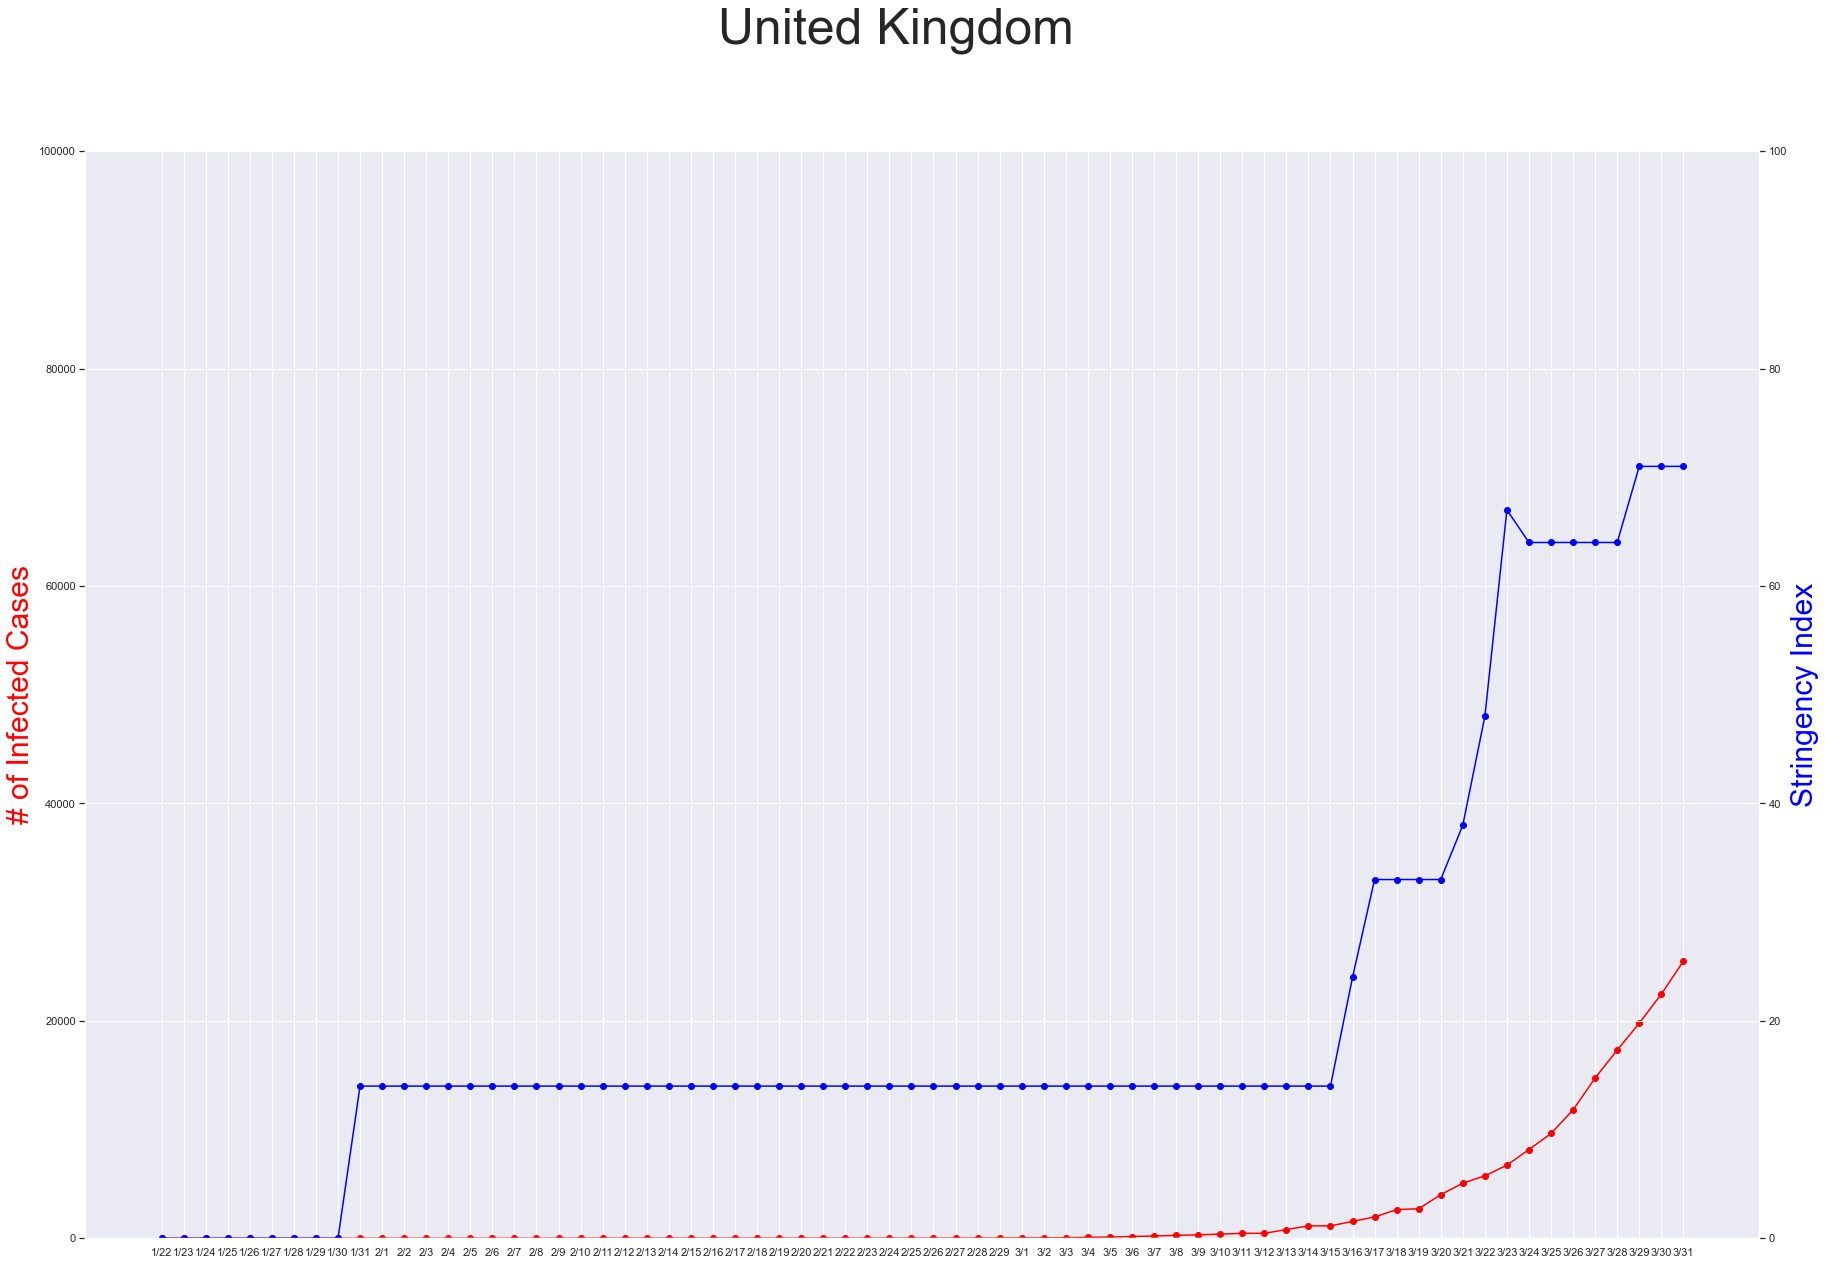

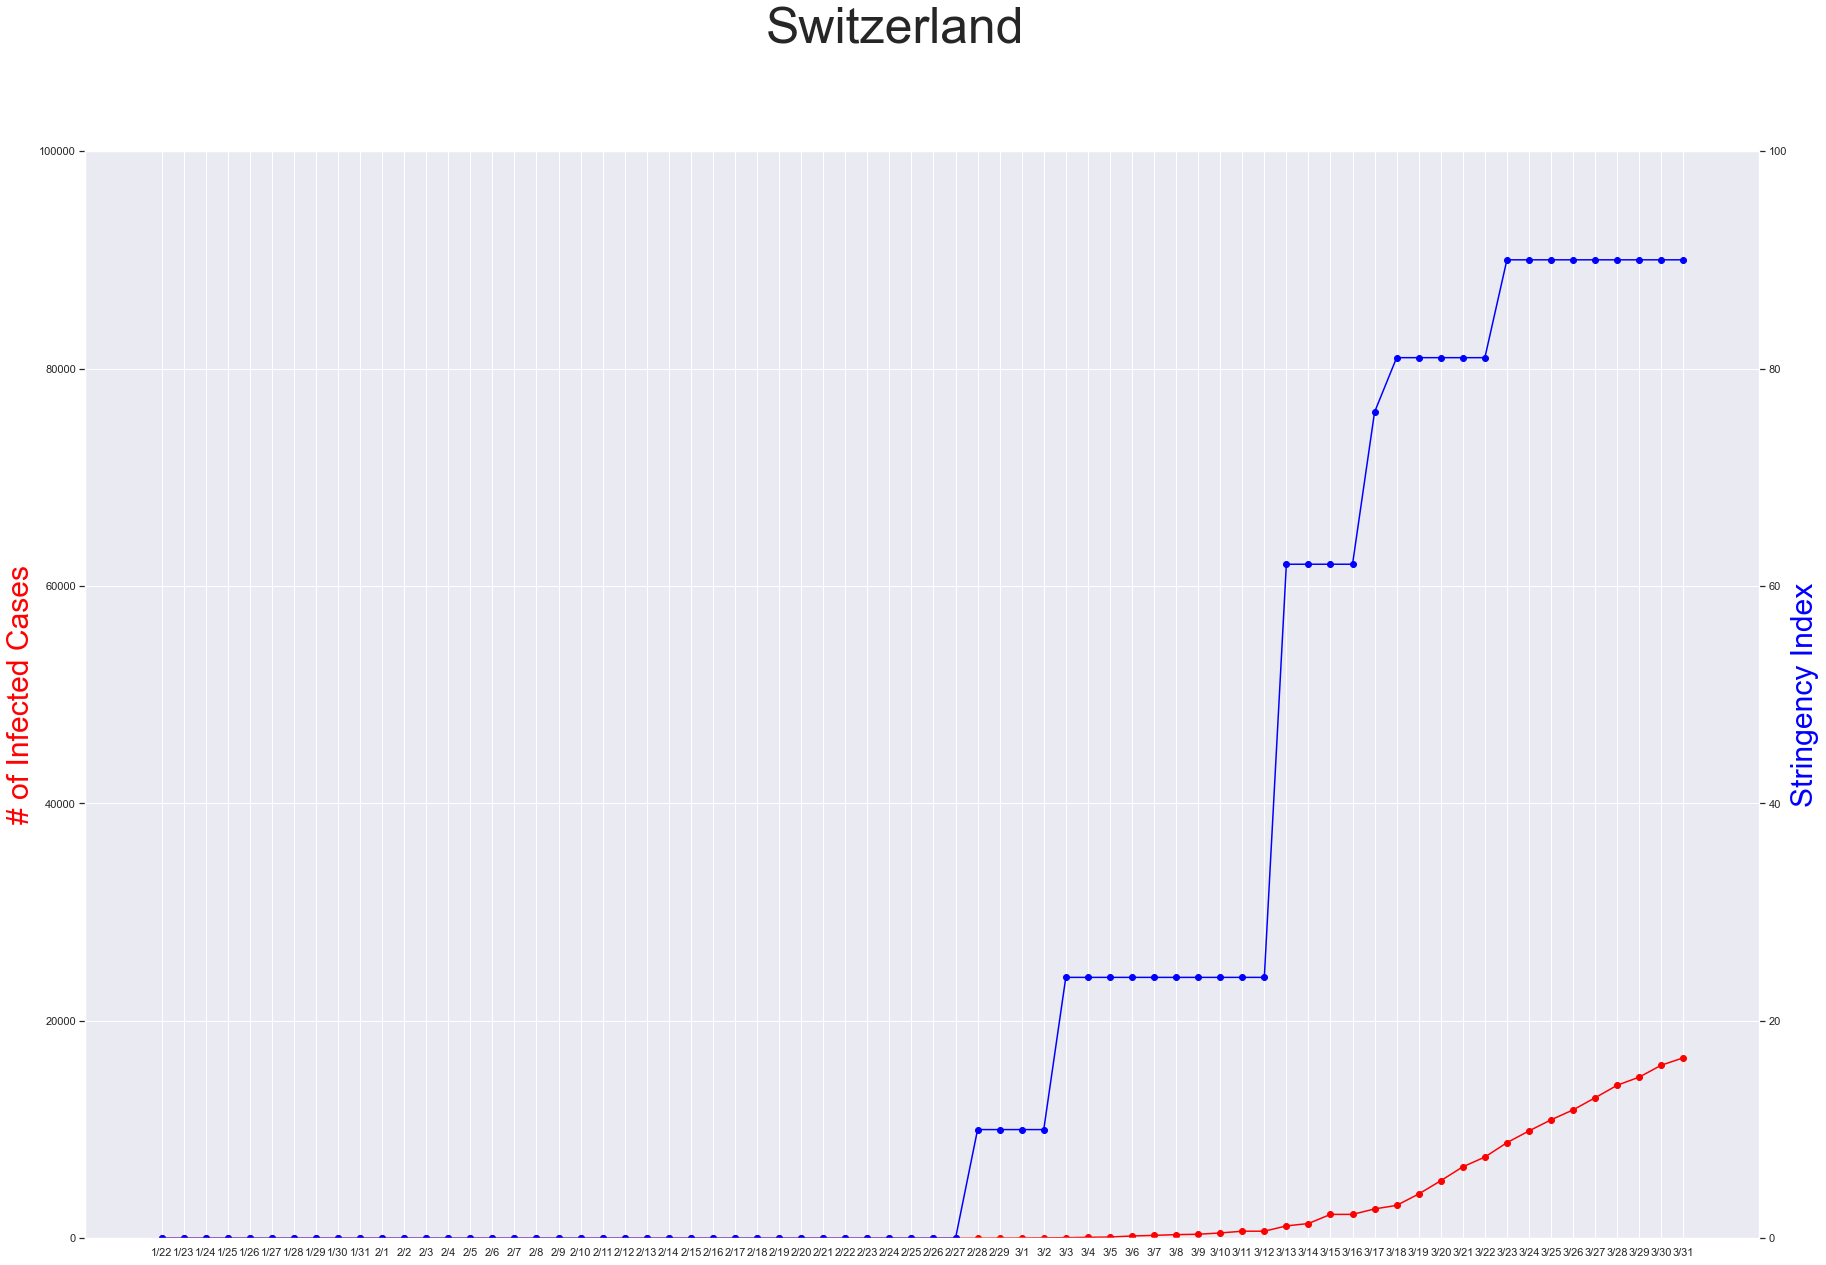

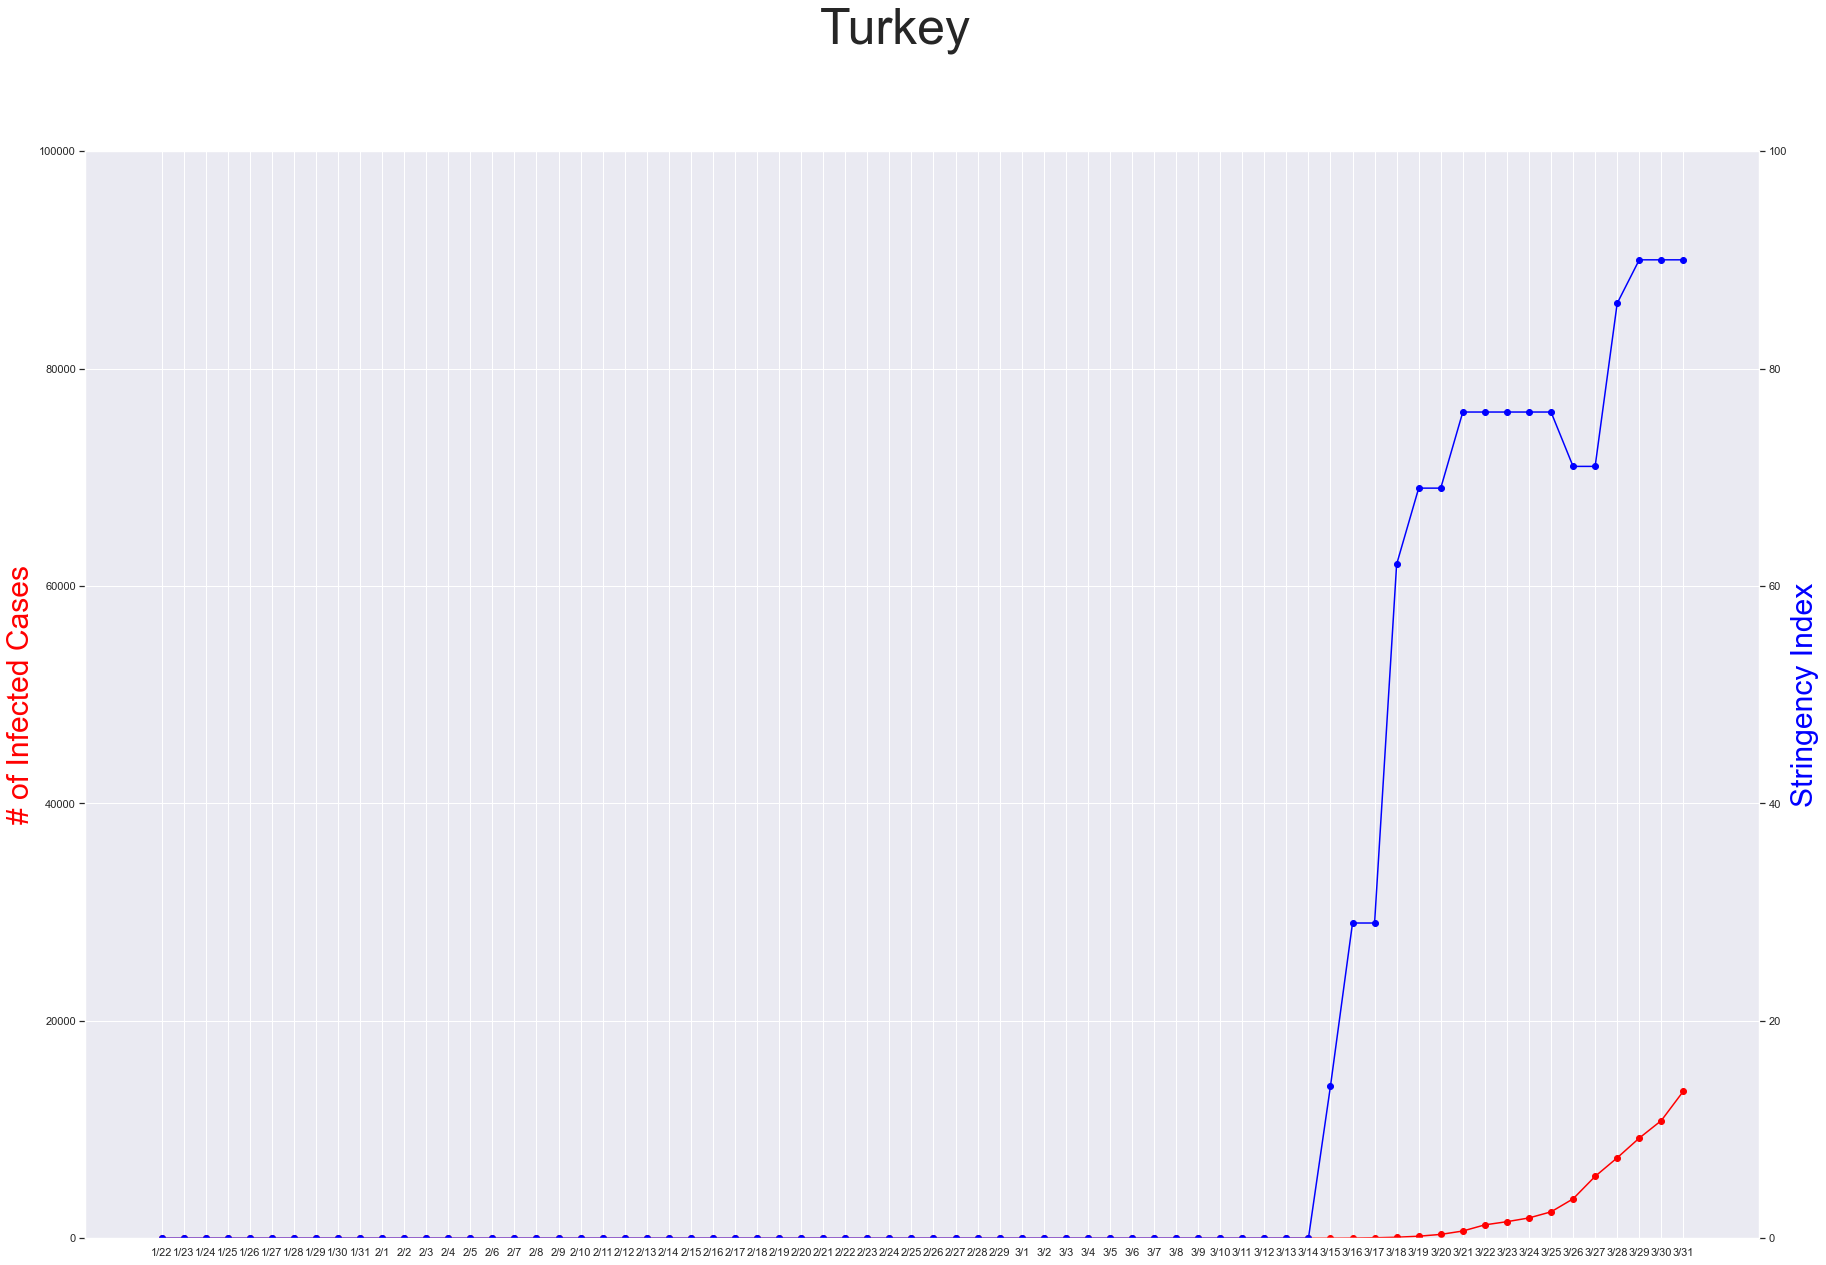

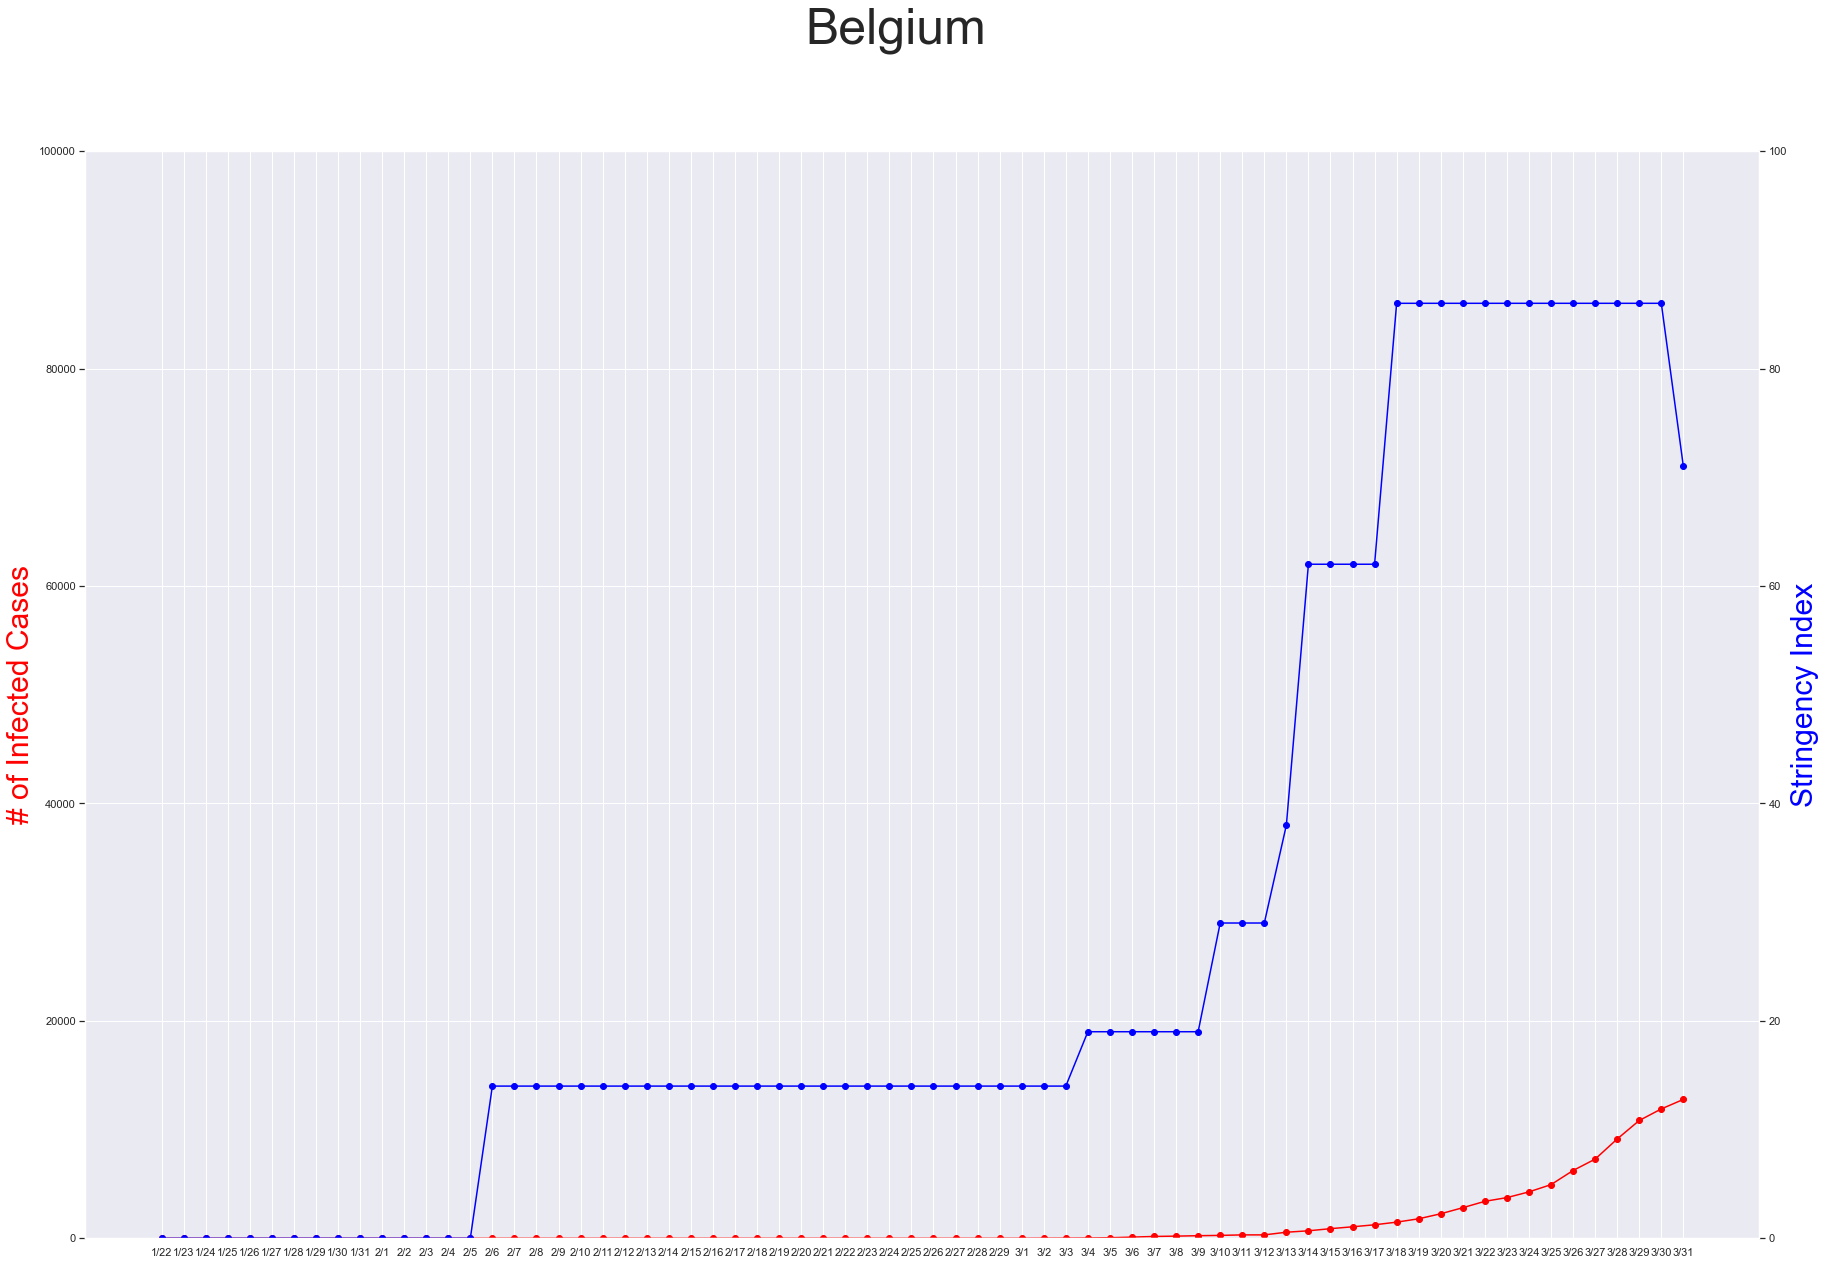

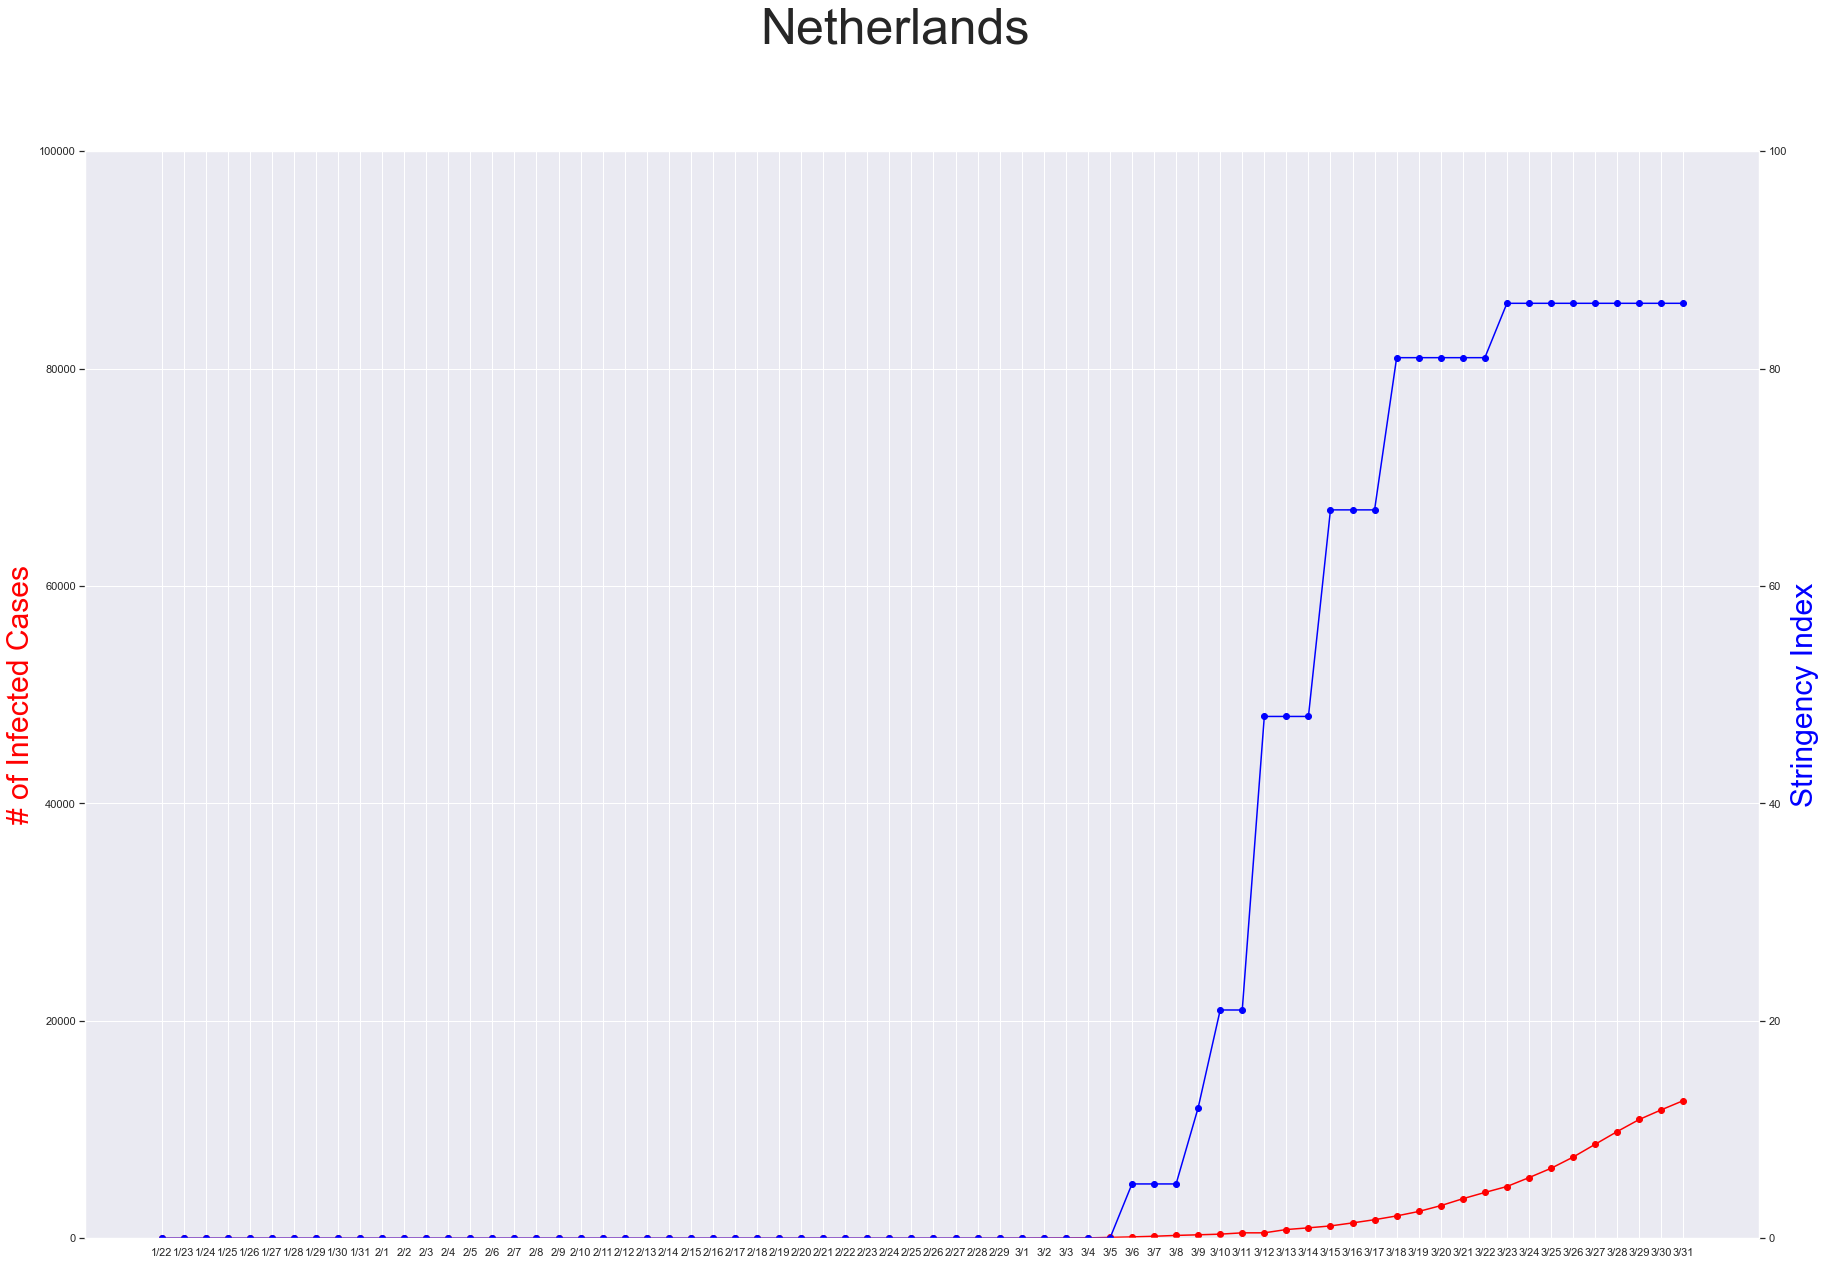

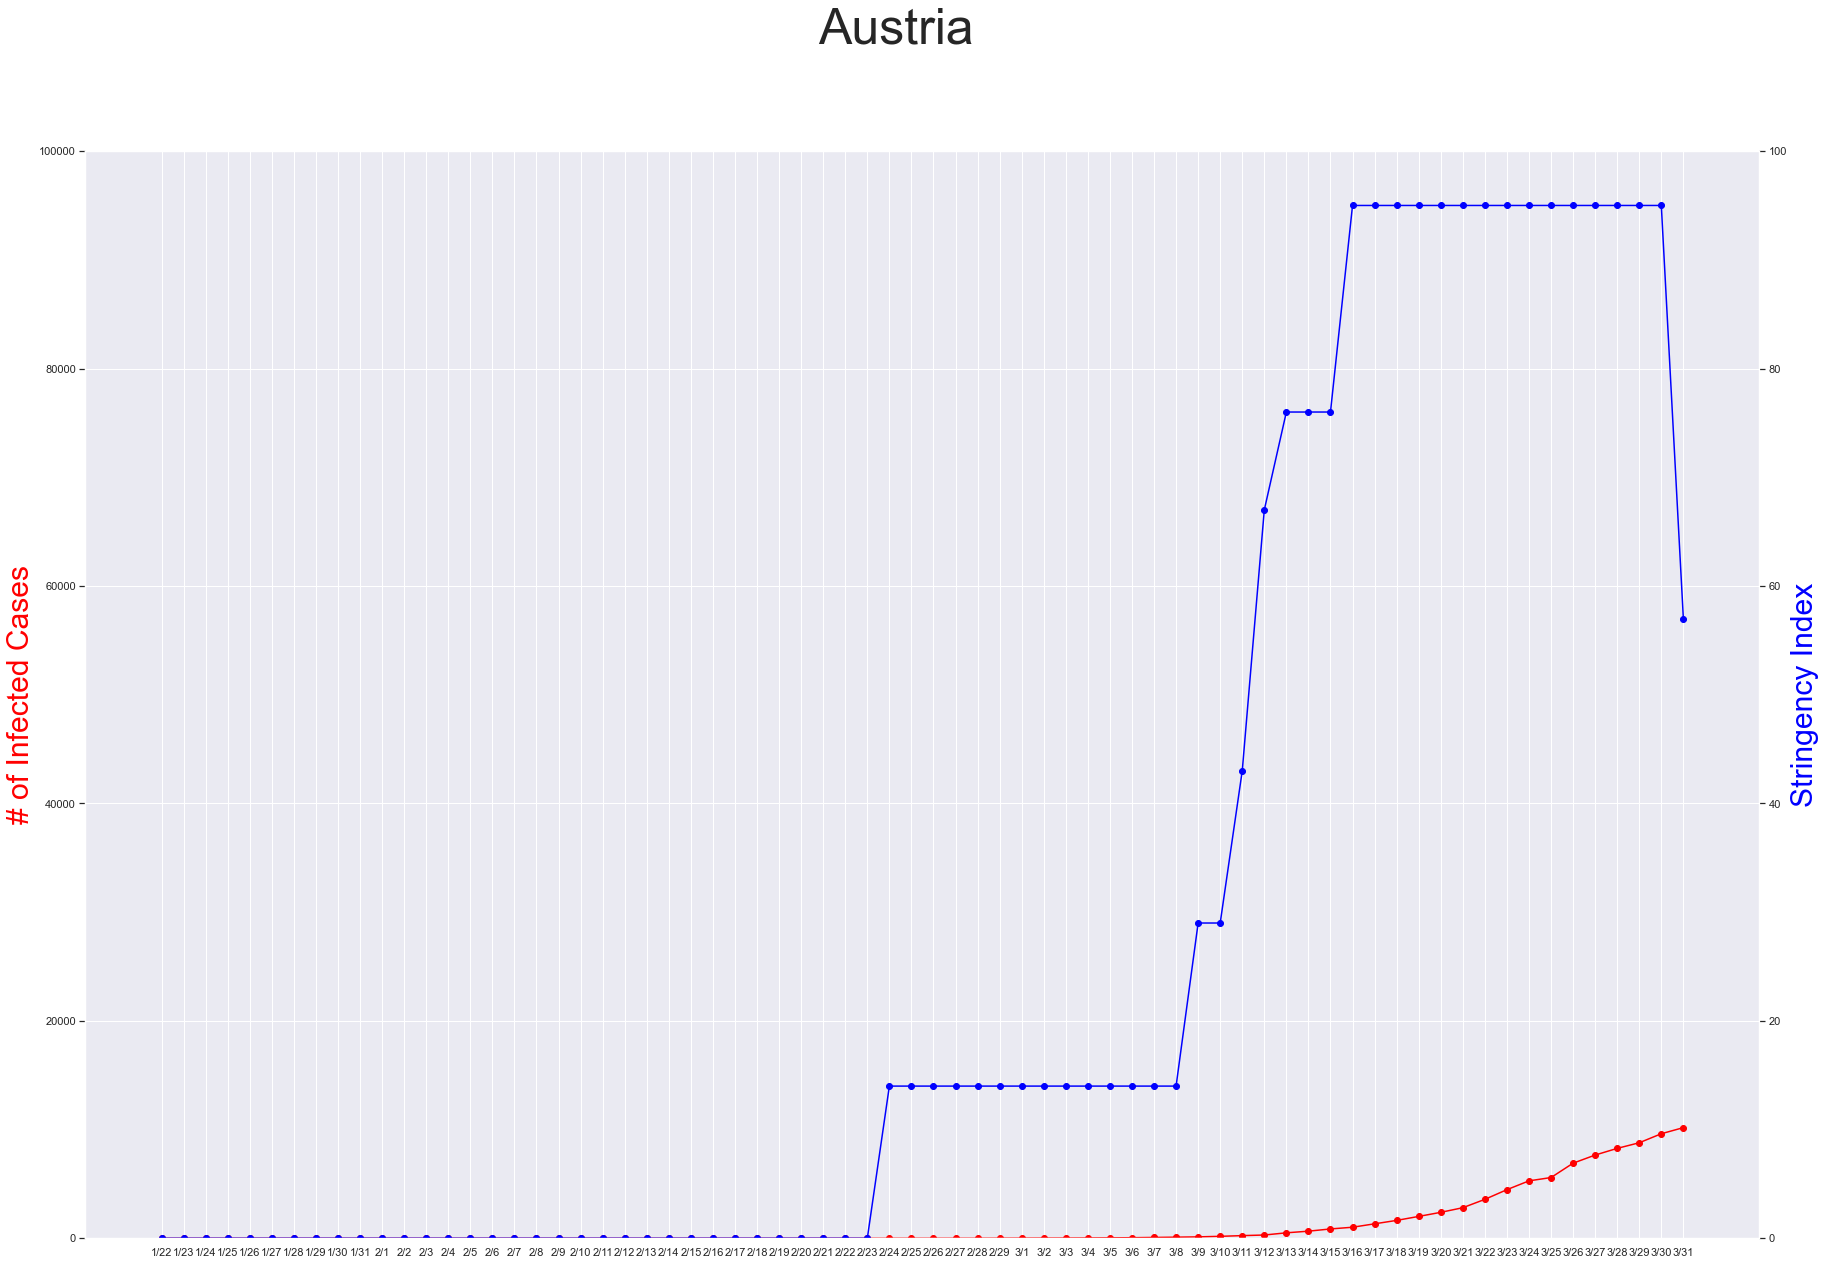

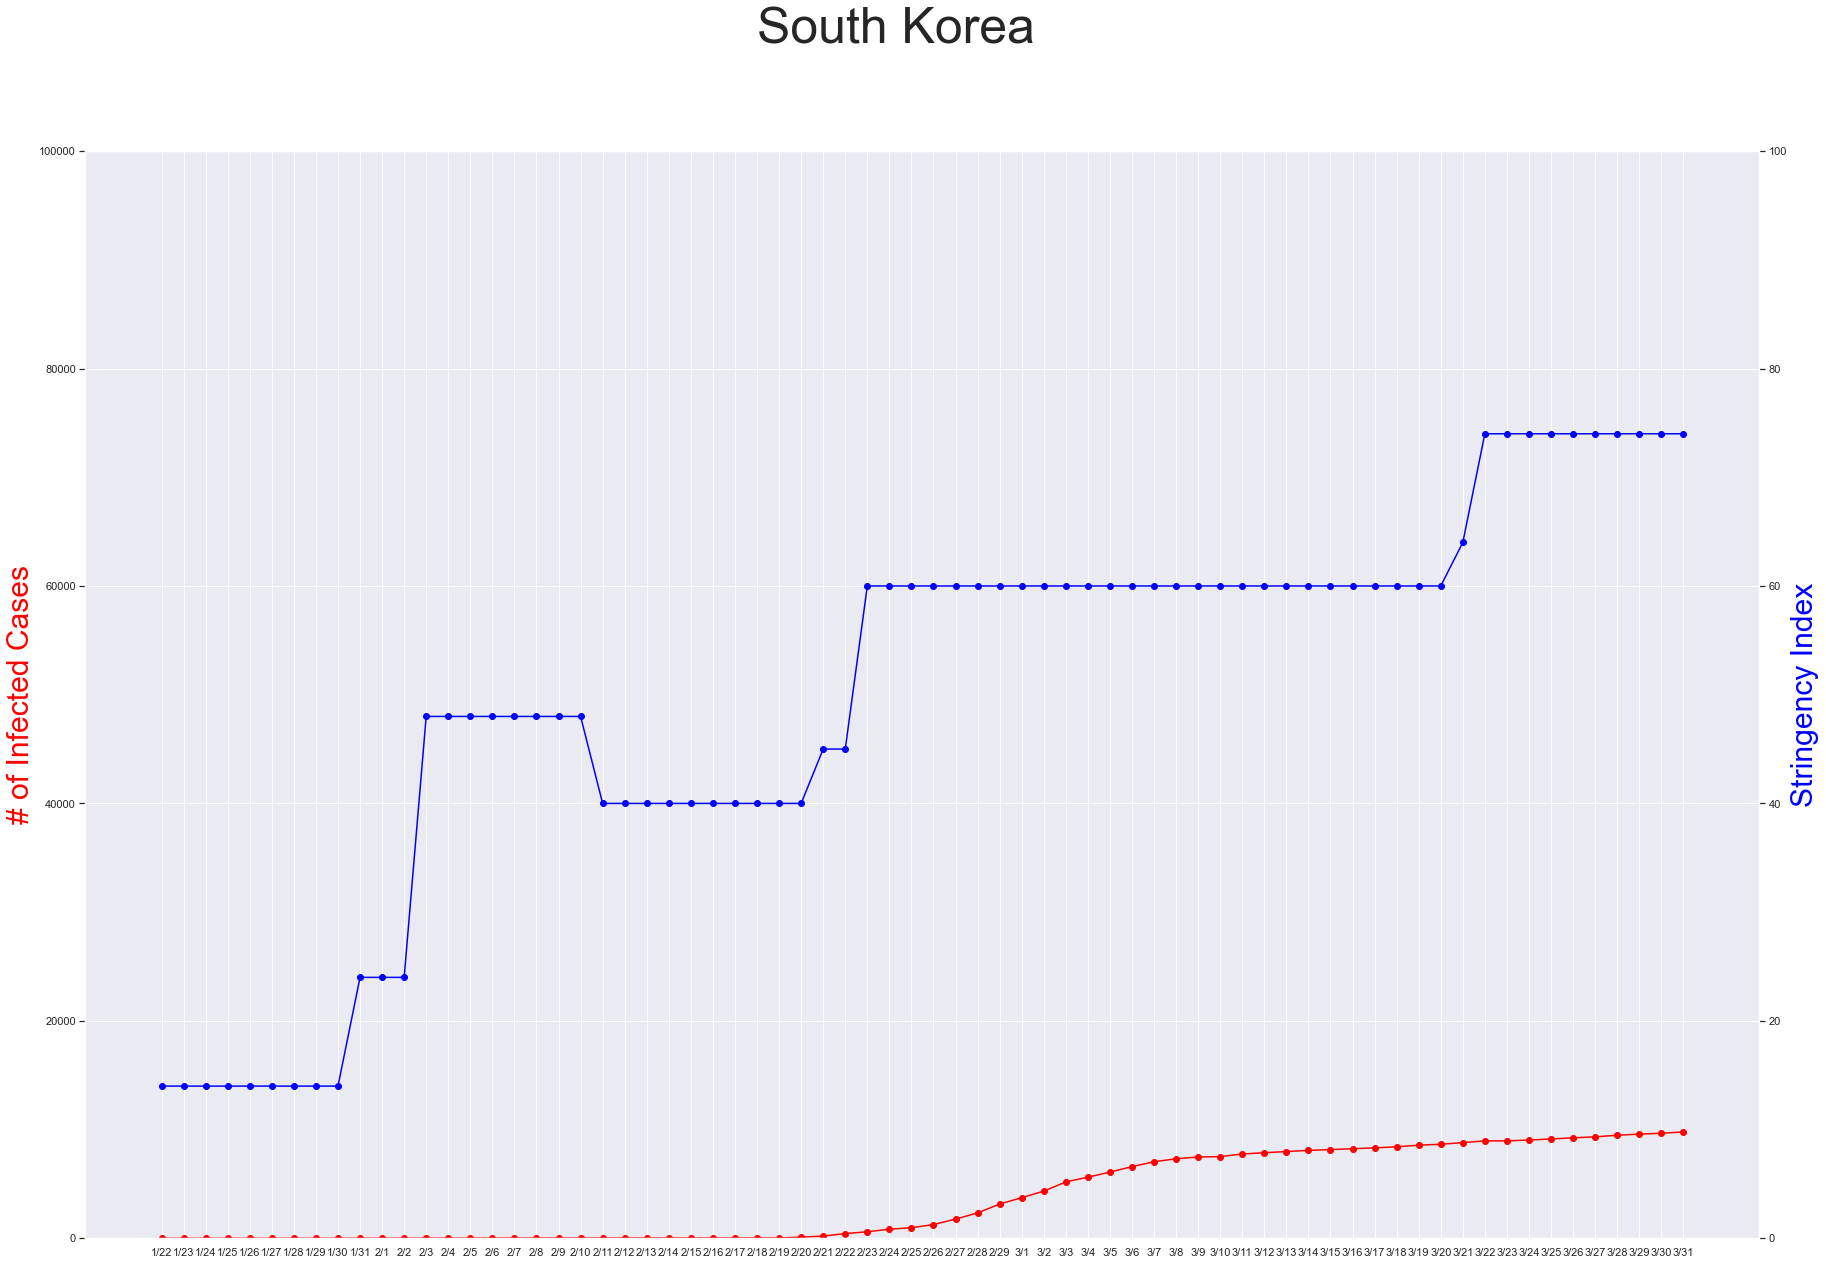

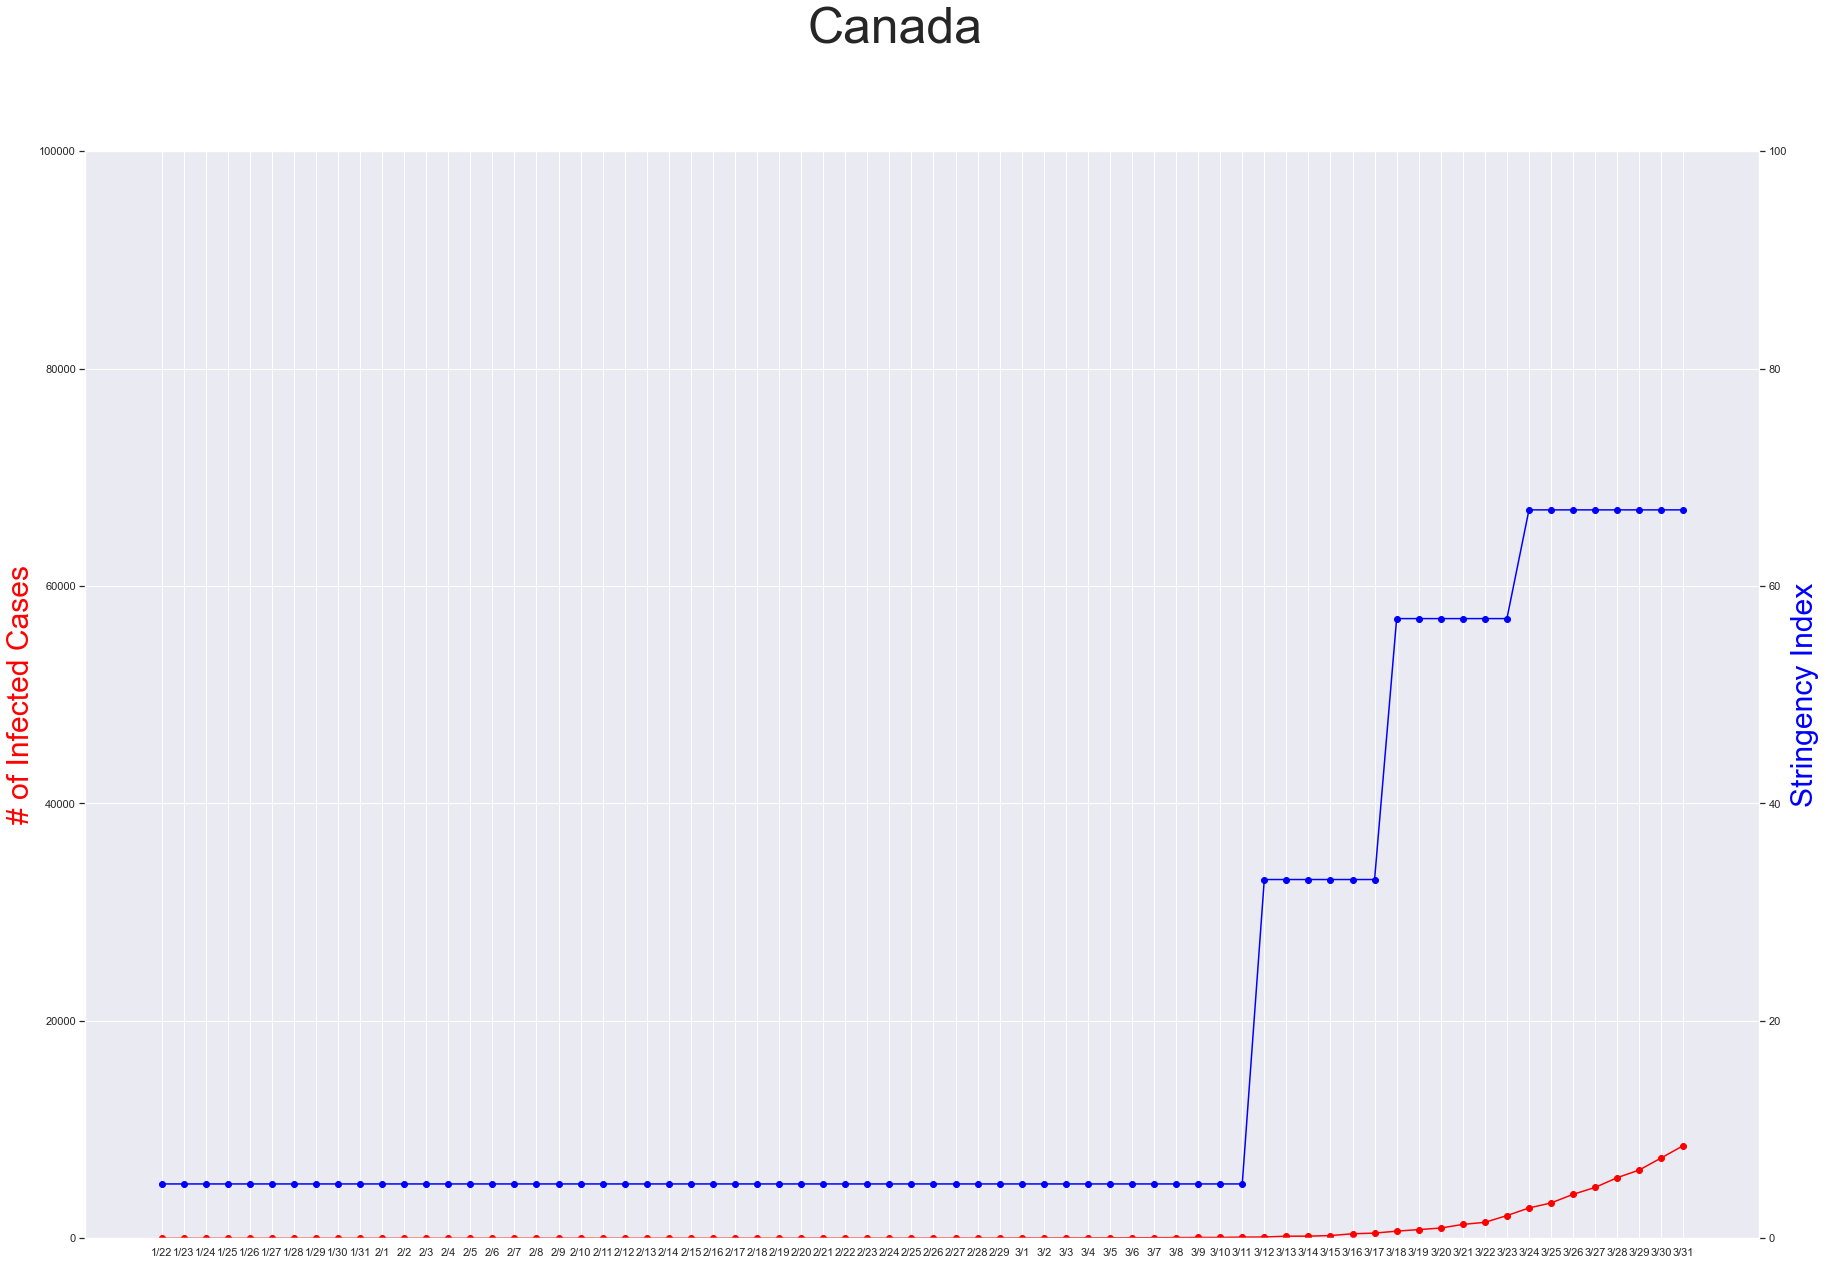

In [453]:
for c in cases_top_n:
    cases_c = pd.DataFrame(cases_gt_100_T[c])
    oxford_string_c = pd.DataFrame(oxford_stringency.T[c])
    merged_c = cases_c.merge(oxford_string_c, left_index=True, right_index=True)
    # correlation = merged_c.corr()
    # print(correlation)
    
    fig,ax = plt.subplots()
    fig.suptitle(c, fontsize=50)
    # ax.text(0.1, 0.1, "Correlation: %.4f" % correlation.iloc[1][0])
    ax.plot(merged_c.index.str.slice(stop=-3), merged_c[c + "_x"], marker="o", color="red")
    ax.set_ylim([0, 100000])
    ax.set_ylabel("# of Infected Cases",color="red",fontsize=30)
    
    ax2 = ax.twinx()
    ax2.plot(merged_c.index.str.slice(stop=-3), merged_c[c + "_y"], marker="o", color="blue")
    ax2.set_ylim([0, 100])
    ax2.set_ylabel("Stringency Index",color="blue",fontsize=30)
    plt.show()
    fig.savefig("Figures/stringency_%s.png" % c )

## Humanitarian aid to country based on Socio-Economic factors. 
https://www.kaggle.com/hellbuoy/pca-kmeans-hierarchical-clustering



In [259]:
economic_data = pd.read_csv(os.path.join(data_dirname, "Country-data.csv"))
economic_data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


## Population by Country - 2020
https://www.kaggle.com/tanuprabhu/population-by-country-2020

Used for setting an upper bound on the maximum value parameter when fitting a logistic curve.

In [336]:
population_data = pd.read_csv(os.path.join(data_dirname, "population_by_country_2020.csv"))
population_data

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%
...,...,...,...,...,...,...,...,...,...,...,...
230,Montserrat,4992,0.06%,3,50,100,NaN,N.A.,N.A.,10%,0.00%
231,Falkland Islands,3480,3.05%,103,0,12170,NaN,N.A.,N.A.,66%,0.00%
232,Niue,1626,0.68%,11,6,260,NaN,N.A.,N.A.,46%,0.00%
233,Tokelau,1357,1.27%,17,136,10,NaN,N.A.,N.A.,0%,0.00%


In [337]:
# Preprocessing: make only population column remain and make country the indx
population_data = population_data[
    ["Country (or dependency)", "Population (2020)"]
]
population_data.set_index("Country (or dependency)", inplace=True)
# avoid 0 divide by rough average of population in each country
population_data.fillna(4 * np.power(10, 8), inplace=True) 

### Explore number of cases as proportion of population

In [338]:
# Merge cases with population 
cases_wt_population = cases_gt_100.merge(
    population_data, 
    right_index=True, left_index=True, how="left")


In [339]:
# fill empty populations with 1
cases_wt_population["Population (2020)"].fillna(4 * np.power(10, 8), inplace=True)


In [340]:
# Divide each number by population size 
cases_wt_pop_norm = cases_wt_population.drop(
    columns="Population (2020)").div(
    cases_wt_population["Population (2020)"].values, axis=0).T



In [341]:
cases_wt_pop_norm

Country/Region,Afghanistan,Albania,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,Turkey,United States,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza
1/22/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,3.021124e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
1/23/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,3.021124e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.054684e-08,0.000000e+00
1/24/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,6.042248e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.054684e-08,0.000000e+00
1/25/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,6.042248e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.054684e-08,0.000000e+00
1/26/20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.568635e-07,0.000000,0.000000,0.000000,...,0.000000,1.510562e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.054684e-08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3/27/20,0.000003,0.000065,0.000009,0.003456,0.000013,0.000111,1.232555e-04,0.000850,0.000016,0.000274,...,0.000068,3.071184e-04,0.000007,0.000041,0.000217,0.000069,0.000003,0.000004,1.674567e-06,2.275000e-07
3/28/20,0.000003,0.000068,0.000010,0.003986,0.000015,0.000137,1.427457e-04,0.000918,0.000018,0.000280,...,0.000088,3.670001e-04,0.000008,0.000047,0.000255,0.000079,0.000003,0.000004,1.787575e-06,2.450000e-07
3/29/20,0.000003,0.000074,0.000012,0.004323,0.000016,0.000143,1.562360e-04,0.000976,0.000021,0.000293,...,0.000109,4.256341e-04,0.000011,0.000058,0.000291,0.000088,0.000004,0.000004,1.931403e-06,2.725000e-07
3/30/20,0.000004,0.000077,0.000013,0.004789,0.000018,0.000163,1.710204e-04,0.001068,0.000027,0.000303,...,0.000128,4.888390e-04,0.000013,0.000062,0.000331,0.000089,0.000004,0.000005,2.085504e-06,2.900000e-07


In [342]:
cases_wt_population[cases_wt_population.index == "Czechia"]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,Population (2020)
Country/Region,,,,,,,,,,,,,,,,,,,,,
Czechia,0,0,0,0,0,0,0,0,0,0,...,1236,1394,1654,1925,2279,2631,2817,3001,3308,400000000.0


In [343]:
cases_wt_pop_norm[cases_top_n]["Czechia"]

1/22/20    0.000000
1/23/20    0.000000
1/24/20    0.000000
1/25/20    0.000000
1/26/20    0.000000
             ...   
3/27/20    0.000006
3/28/20    0.000007
3/29/20    0.000007
3/30/20    0.000008
3/31/20    0.000008
Name: Czechia, Length: 70, dtype: float64

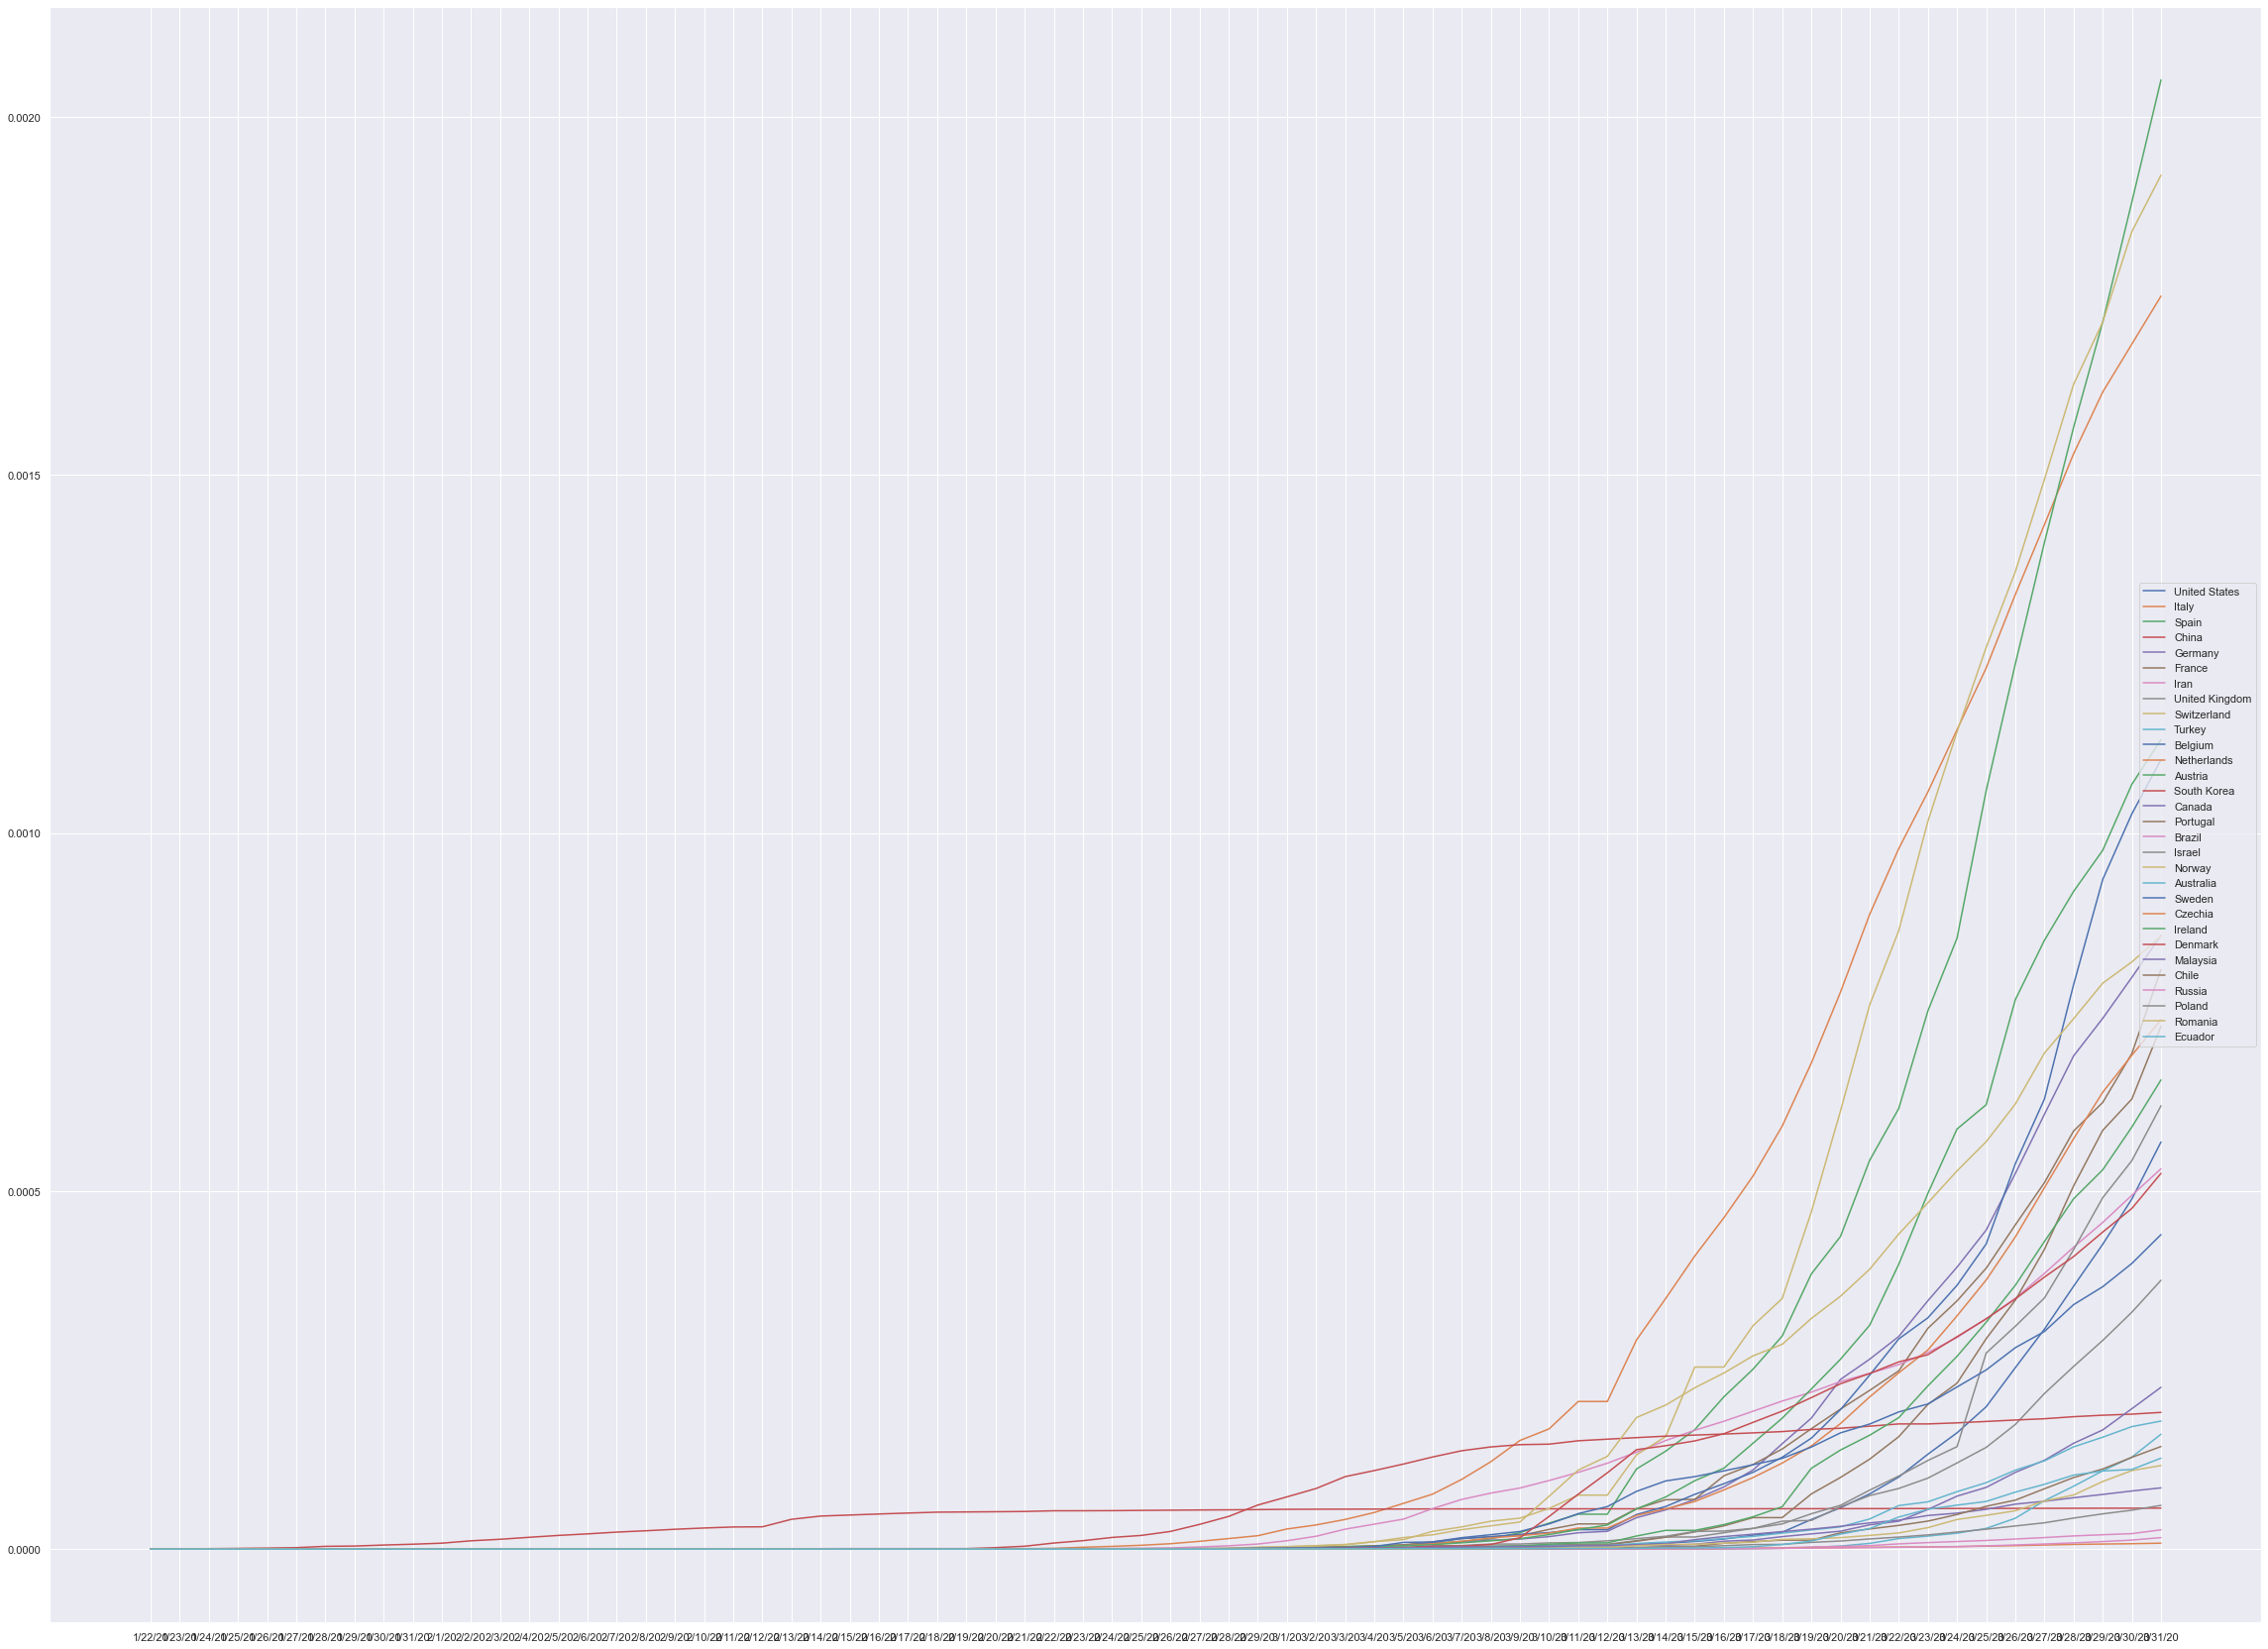

In [344]:
plt.plot(cases_wt_pop_norm[cases_top_n])
plt.legend(cases_top_n, loc='center right')

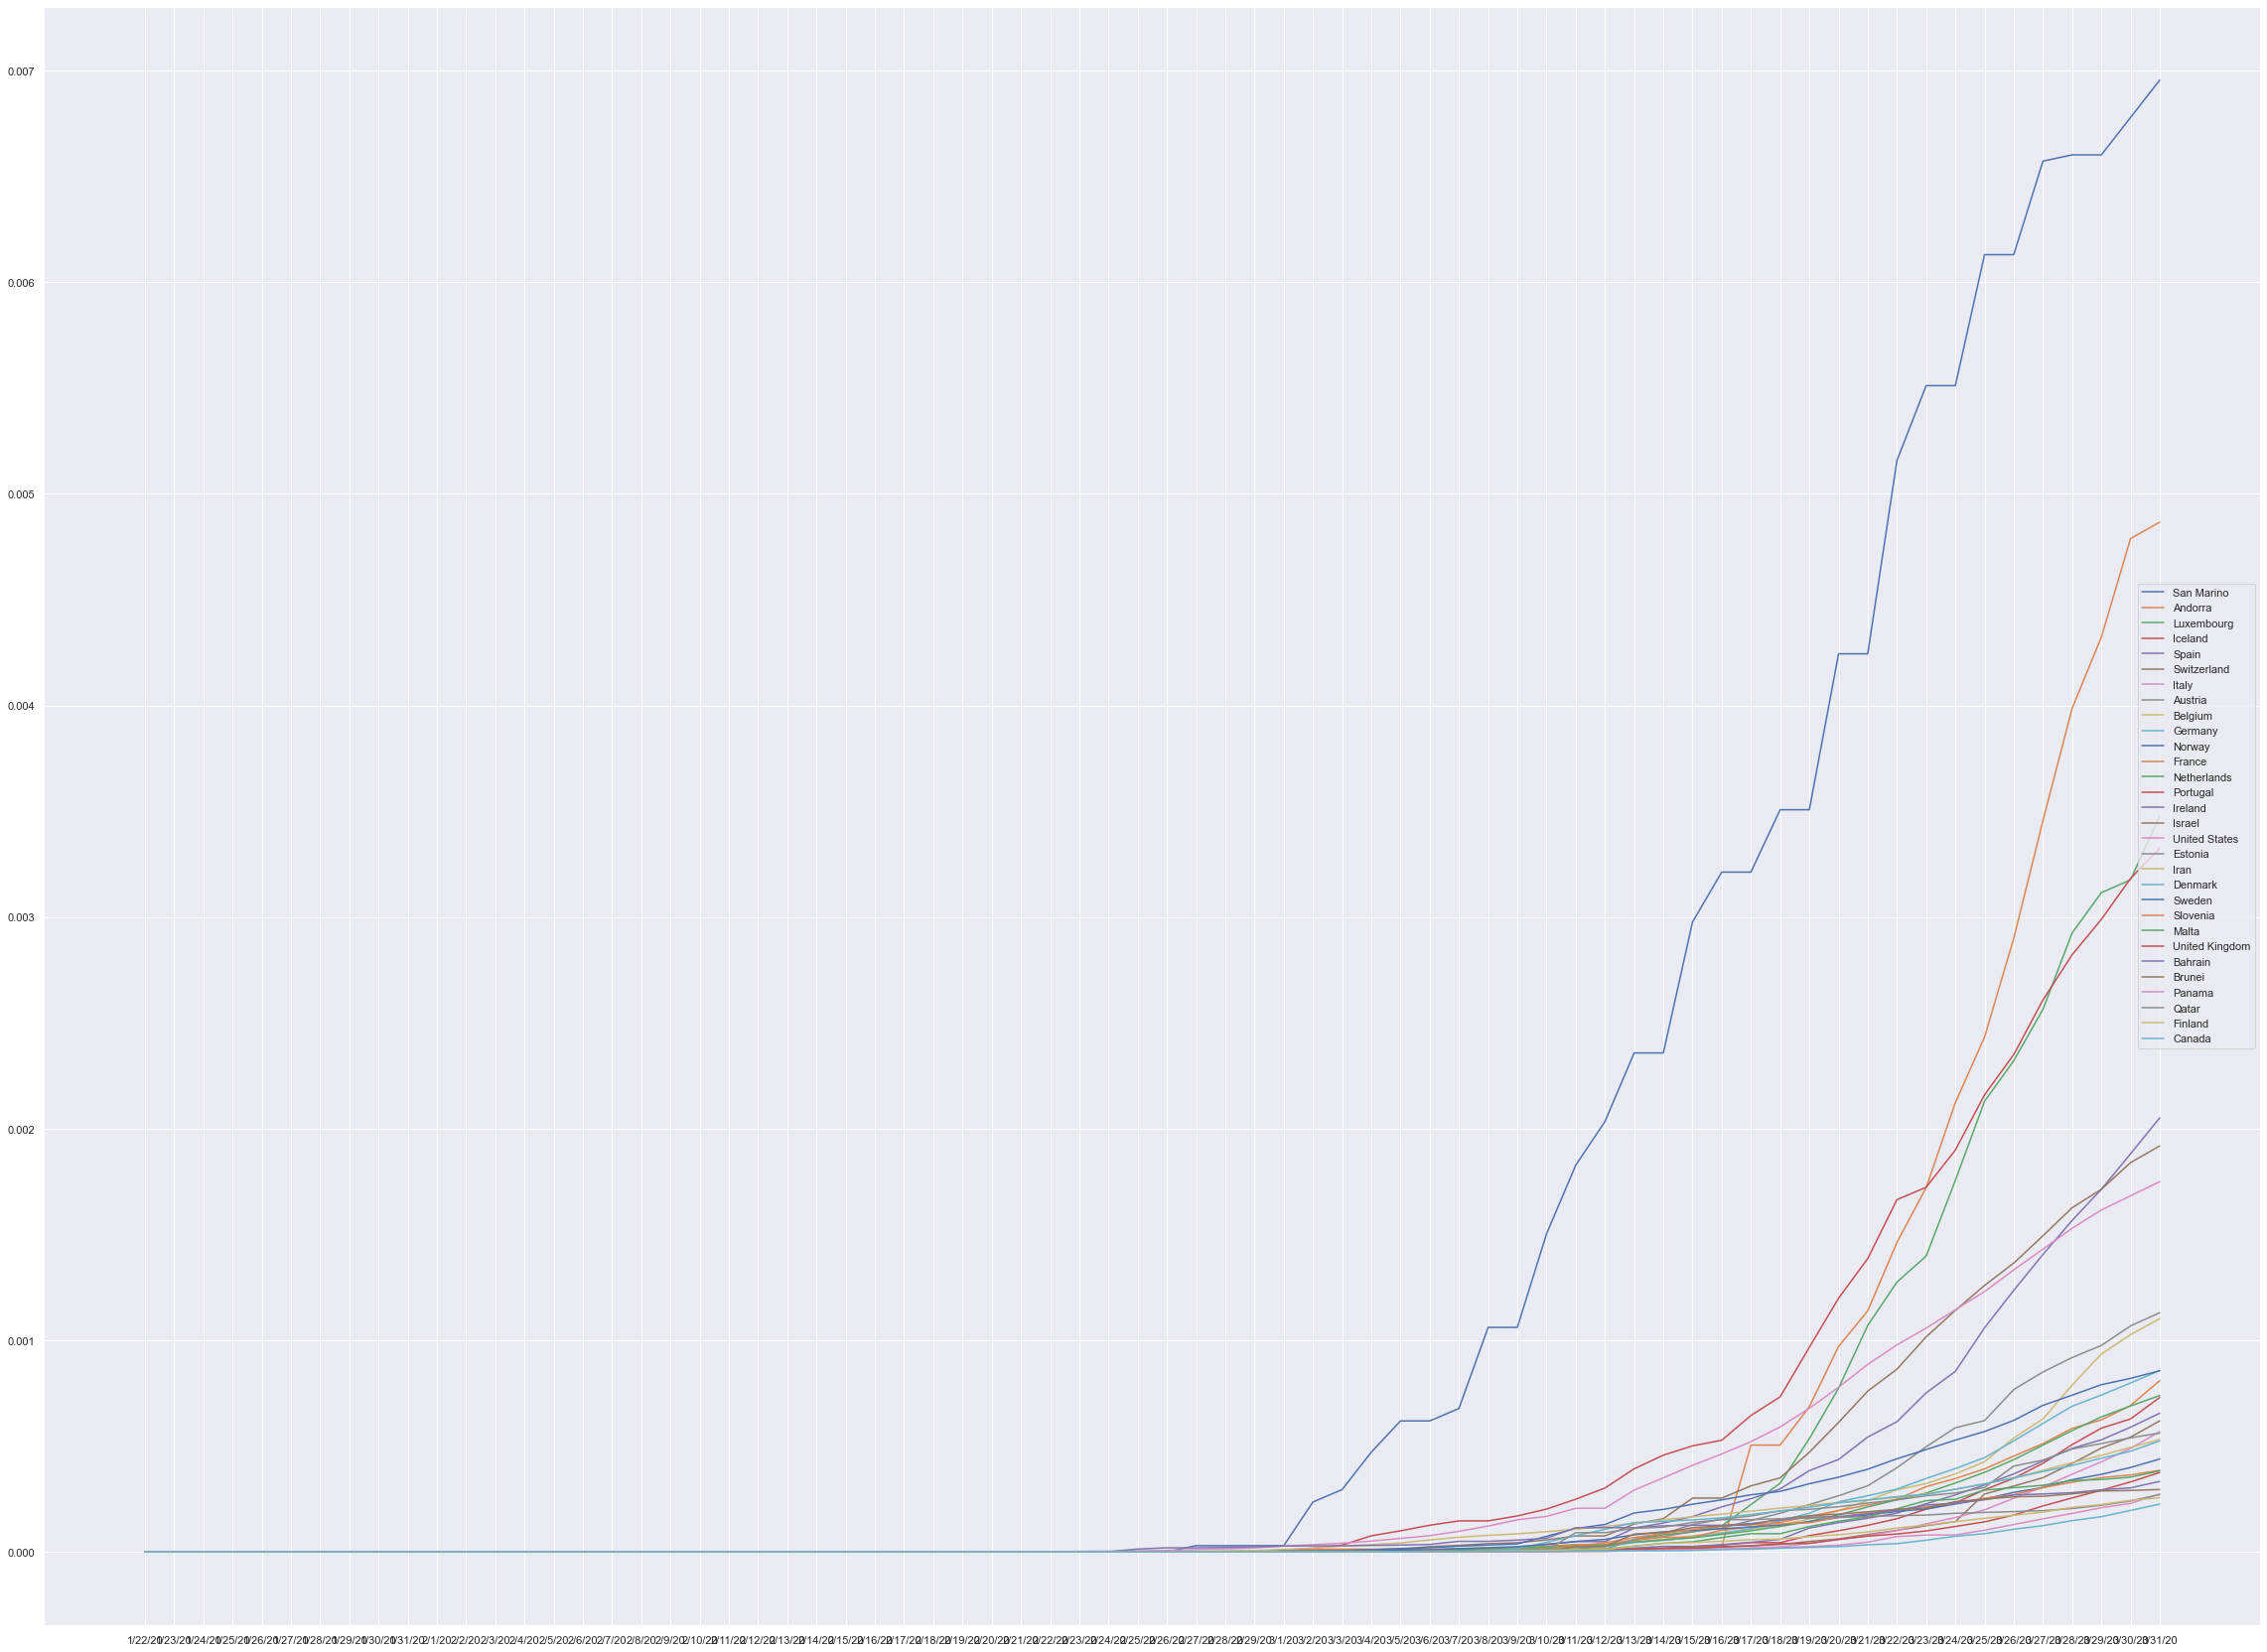

In [218]:
# Top 30 in terms of # of cases in proportion to its population
cases_wt_pop_top_n = cases_wt_pop_norm.T.nlargest(30, current_date).index.values

plt.plot(cases_wt_pop_norm[cases_wt_pop_top_n])
plt.legend(cases_wt_pop_top_n, loc='center right')

# 2. Analyze the before/after impact of various government measures

a comparison between the trajectory of confirmed cases before the implementation and the observed number of cases after the measure is implemented

## First, fit the logistic function

In [ ]:
# sigmoid functions 
x_0 = 0 # midpoint
def sigmoid (x, L, slope, offset):
    
    return L / (1 + np.exp ((x - x_0 / slope))

In [ ]:
for country in cases_top_n:
    